In [1]:
import pickle 
from pathlib import Path 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# load precalculated embeddings

In [2]:
DATA_DIR = Path().absolute().parent / 'data'

with open(DATA_DIR / 'embeddings.pickle', 'rb') as f:
    embeddings_deepface = pickle.load(f)

with open(DATA_DIR / 'embeddings_insightface_v3_128x128.pickle', 'rb') as f:
    embeddings_insightface = pickle.load(f)

embeddings = embeddings_deepface | embeddings_insightface
print(embeddings.keys())

dict_keys(['VGG-Face', 'OpenFace', 'Facenet', 'Facenet512', 'DeepFace', 'DeepID', 'Dlib', 'ArcFace', 'SFace', 'buffalo_s', 'buffalo_sc', 'buffalo_m', 'buffalo_l', 'antelopev2'])


In [3]:
def dict2df(model_dict):
    embeddings = []
    labels = []
    is_fake = []
    fnames = []
    for label, embedding in model_dict.items():
        for fname, emb in embedding.items():
            if label == "ck":
                is_fake.append(1)
                labels.append(fname.split(".")[0])
            else:
                is_fake.append(0)
                labels.append(label)
            embeddings.append(np.array(emb["embedding"]))
            fnames.append(fname)
    df = pd.DataFrame({
    "embeddings": embeddings, 
    "labels": labels,
    "fnames": fnames,
    "is_fake": is_fake
    })
    return df

model2df = {model: dict2df(model_dict) for model, model_dict in embeddings.items()}
model2df["Facenet"].head()

embeddings    labels  \
0  [-1.4944489002227783, -1.4114049673080444, -0....  dr_house   
1  [-1.9788538217544556, -1.7696497440338135, -0....  dr_house   
2  [-2.5532069206237793, -0.7926962375640869, -0....  dr_house   
3  [-1.2020866870880127, -1.5620497465133667, -0....  dr_house   
4  [-3.0435636043548584, -2.2254717350006104, -0....  dr_house   

             fnames  is_fake  
0  008_ecae6a22.jpg        0  
1  002_3299cc32.jpg        0  
2  004_00999bba.jpg        0  
3  003_e525969e.jpg        0  
4  009_25abfef1.jpg        0

In [4]:
# l2 normalize embeddings
for model, df in model2df.items():
    embeddings = np.array(df["embeddings"].values.tolist())
    embeddings = embeddings / np.linalg.norm(embeddings, axis=1, keepdims=True)
    df["embeddings_l2norm"] = [embeddings[i] for i in range(len(embeddings))]

model2df["Facenet"].head()

embeddings    labels  \
0  [-1.4944489002227783, -1.4114049673080444, -0....  dr_house   
1  [-1.9788538217544556, -1.7696497440338135, -0....  dr_house   
2  [-2.5532069206237793, -0.7926962375640869, -0....  dr_house   
3  [-1.2020866870880127, -1.5620497465133667, -0....  dr_house   
4  [-3.0435636043548584, -2.2254717350006104, -0....  dr_house   

             fnames  is_fake  \
0  008_ecae6a22.jpg        0   
1  002_3299cc32.jpg        0   
2  004_00999bba.jpg        0   
3  003_e525969e.jpg        0   
4  009_25abfef1.jpg        0   

                                   embeddings_l2norm  
0  [-0.12430799717893216, -0.11740041741695213, -...  
1  [-0.17179989273002746, -0.15363723831059942, -...  
2  [-0.21193597723332583, -0.06579993591599725, -...  
3  [-0.09901870616480456, -0.12866970953608933, -...  
4  [-0.25427499623914257, -0.1859273833600556, -0...

In [47]:
from sklearn.metrics.pairwise import pairwise_distances

x = np.arange(0, 10, 0.5)
dist = pairwise_distances(x.reshape(-1, 1), metric='euclidean')
n = dist.max()
# apply softamx to normalize
dist_norm = np.exp(-dist) / np.exp(-dist).sum(axis=1, keepdims=True)
np.allclose(dist_norm, dist_norm.T)

False

# Display pairwise similiarites

VGG-Face
(117, 2622)


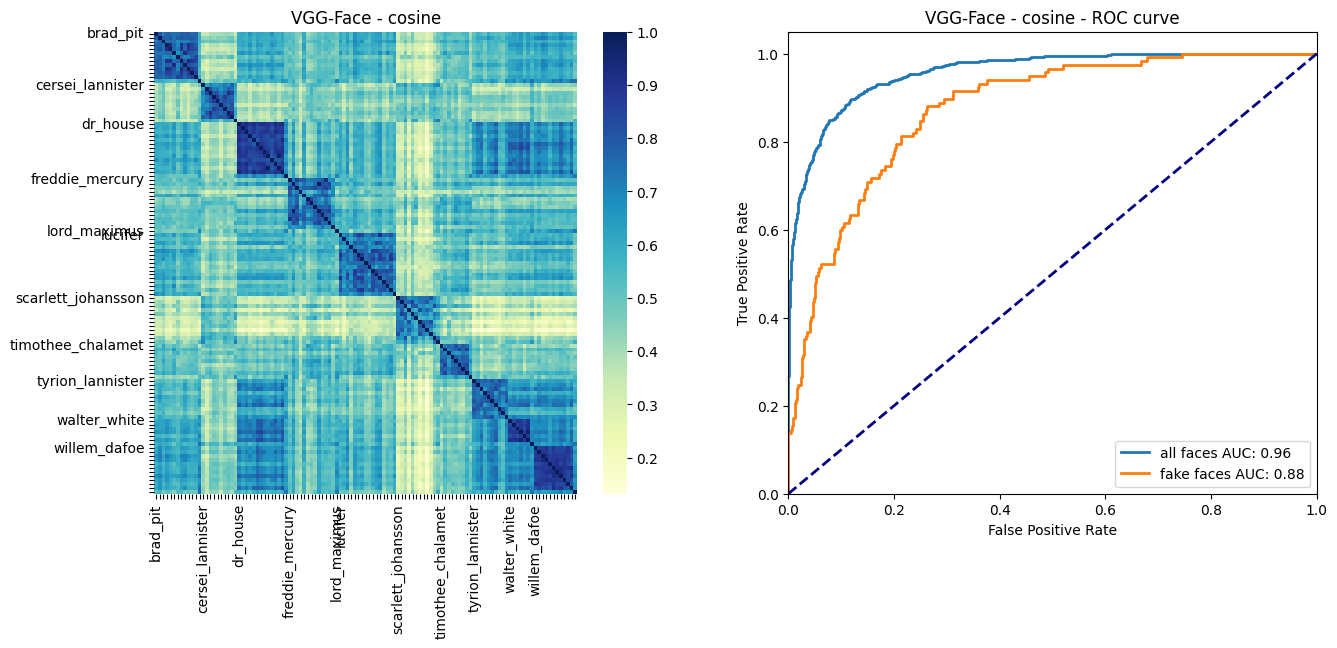

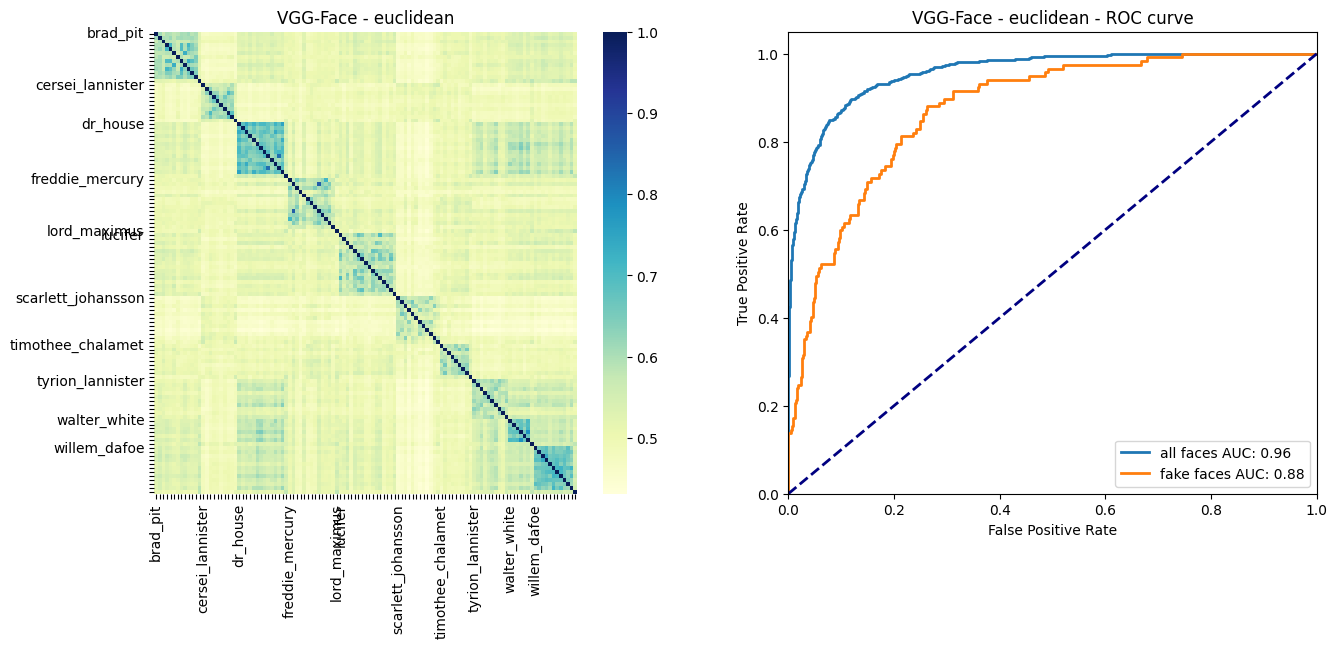

OpenFace
(117, 128)


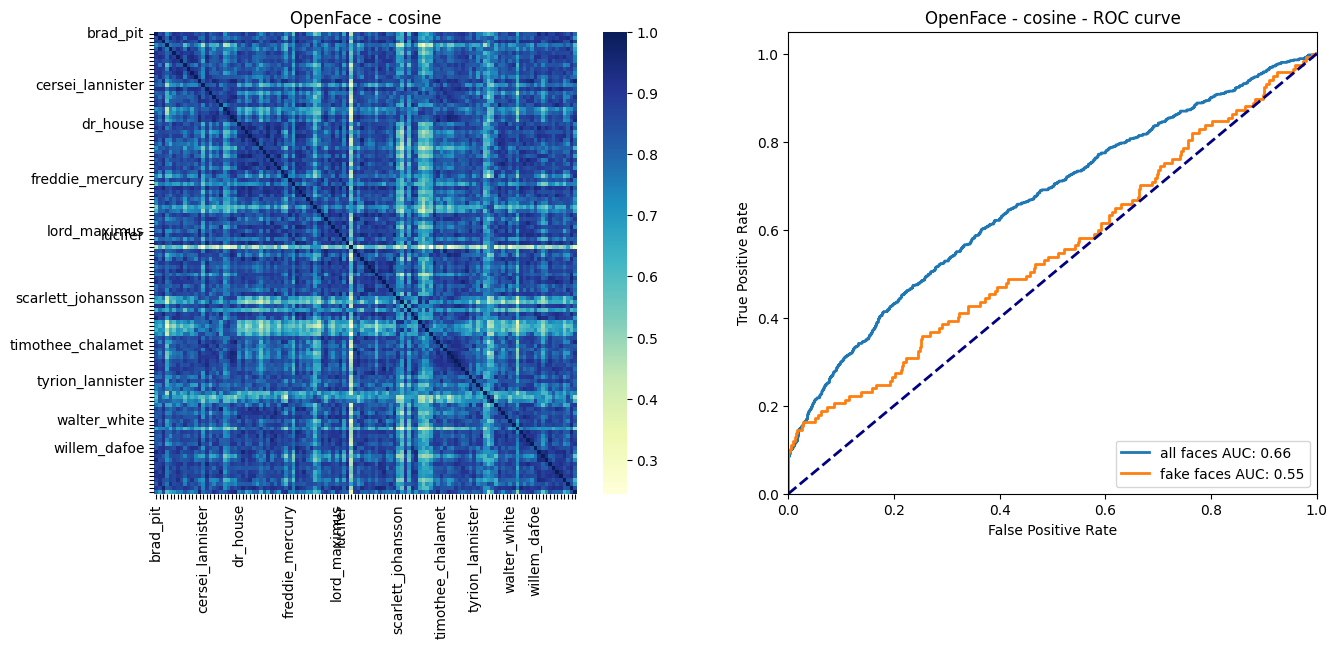

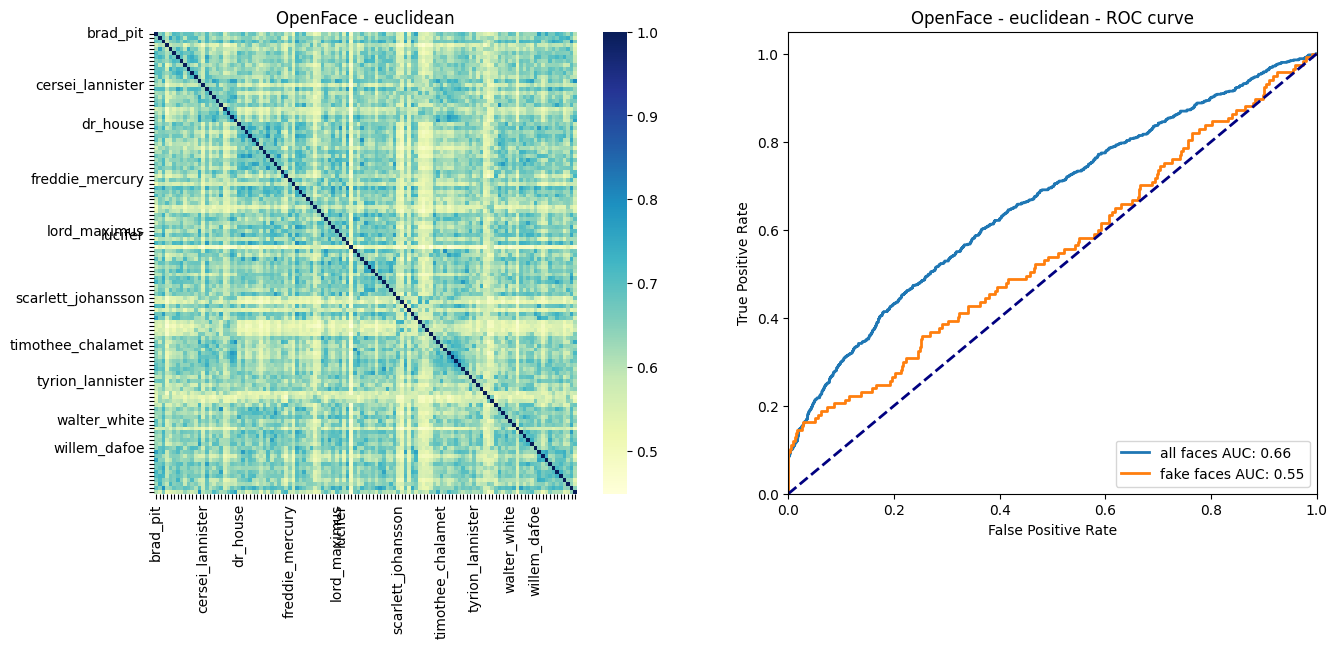

Facenet
(117, 128)


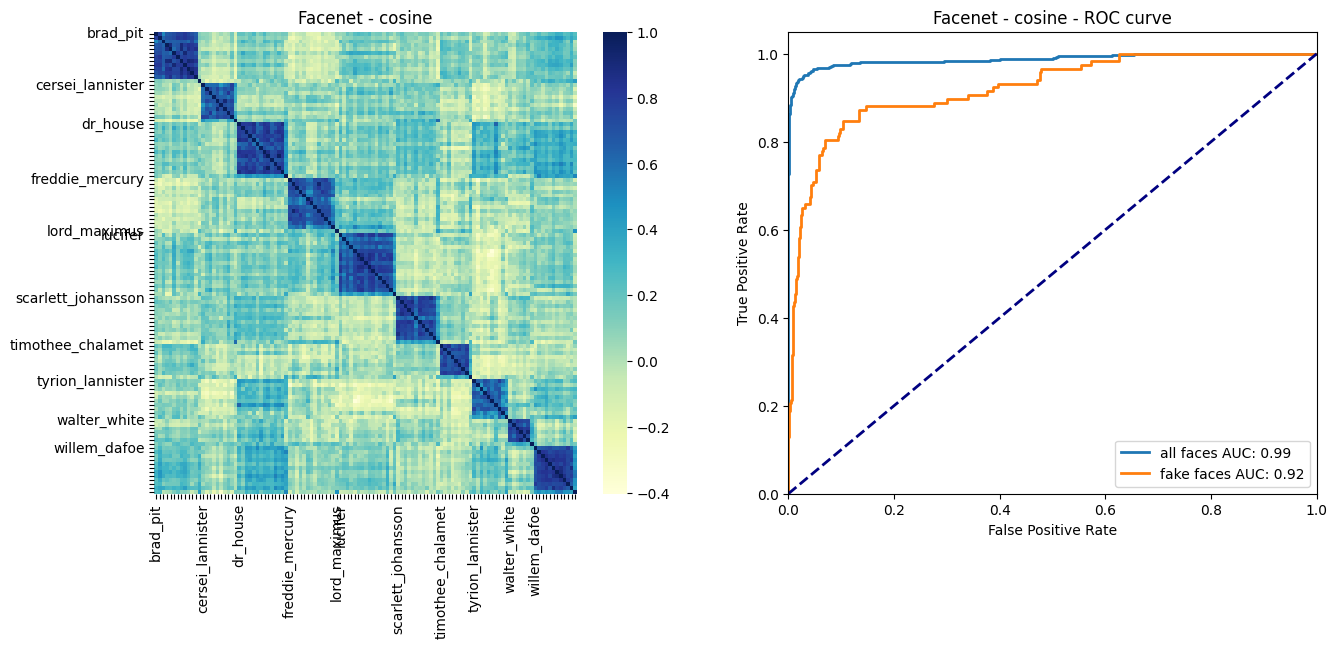

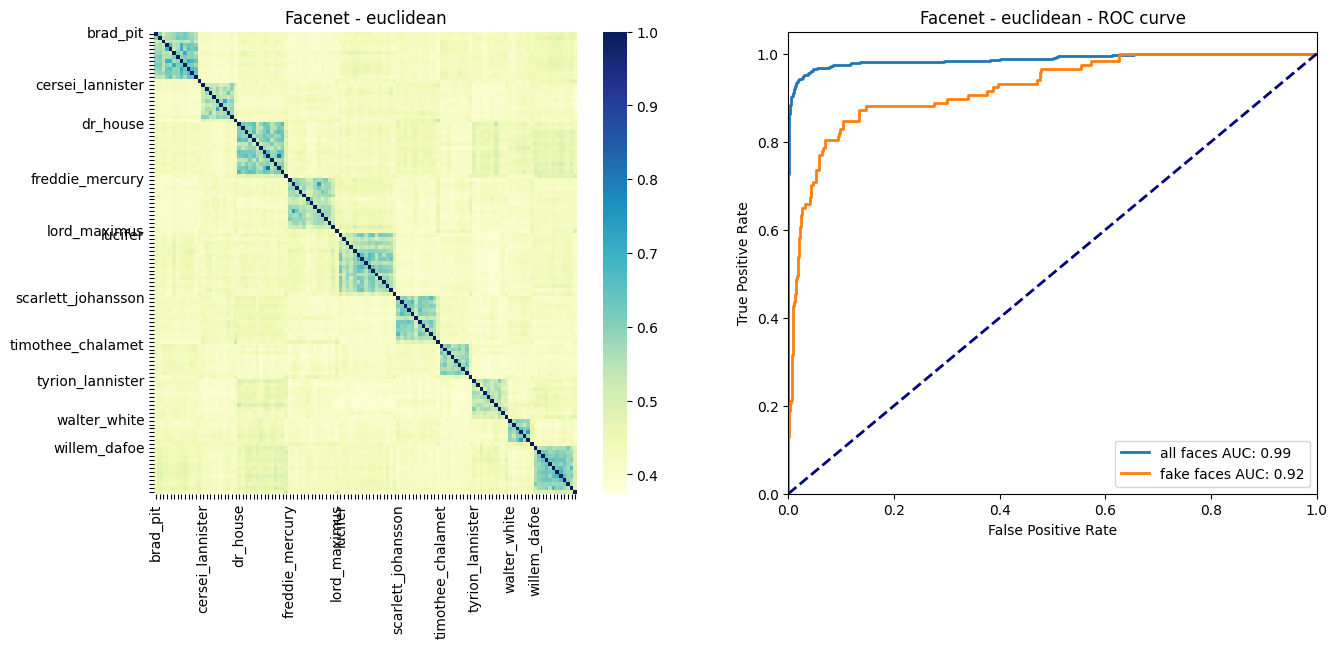

Facenet512
(117, 512)


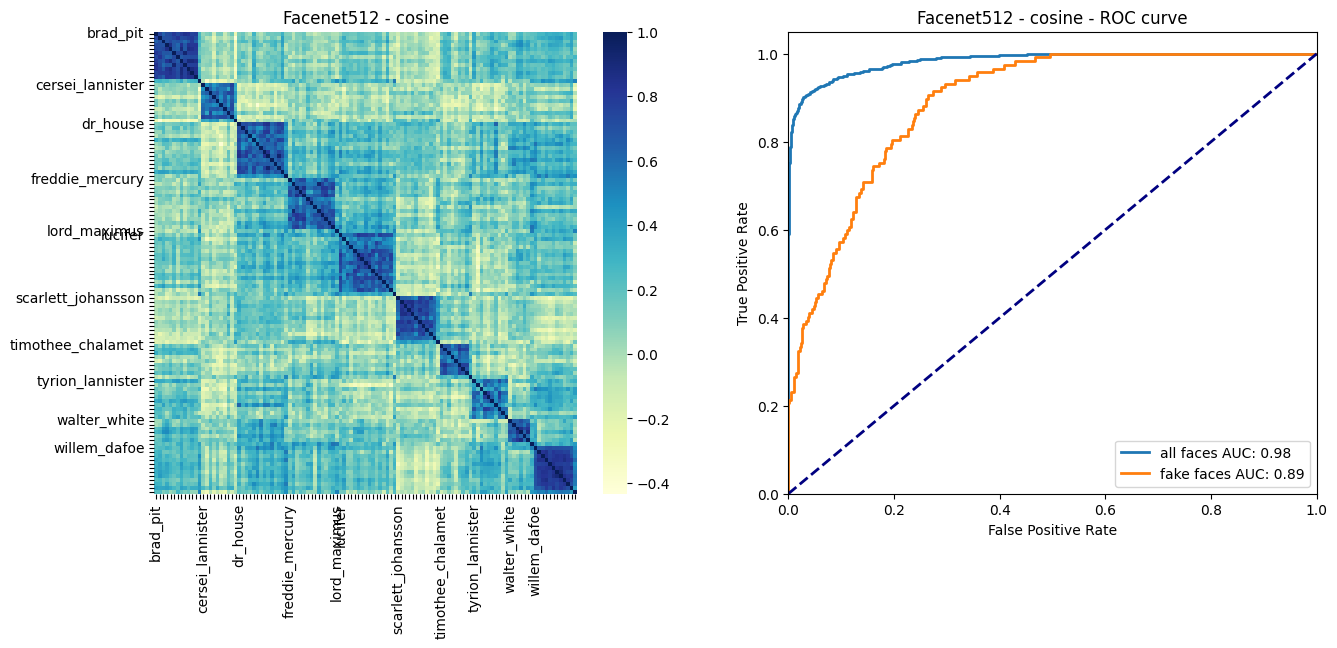

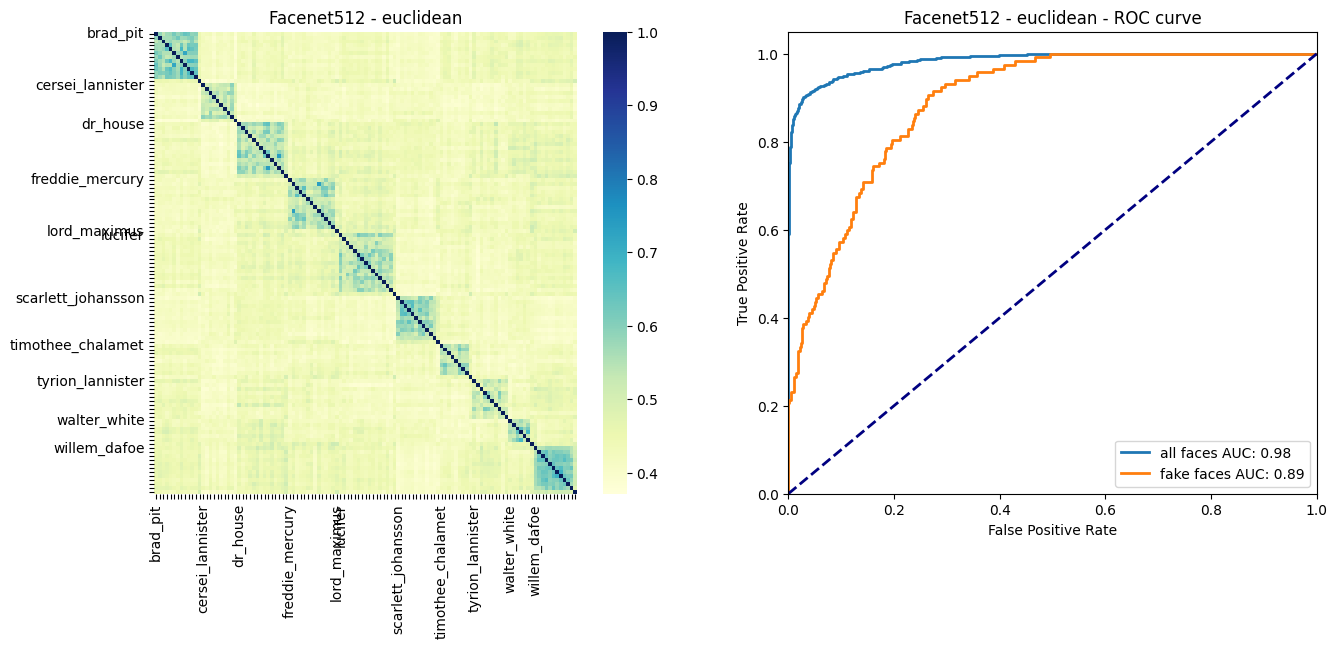

DeepFace
(117, 4096)


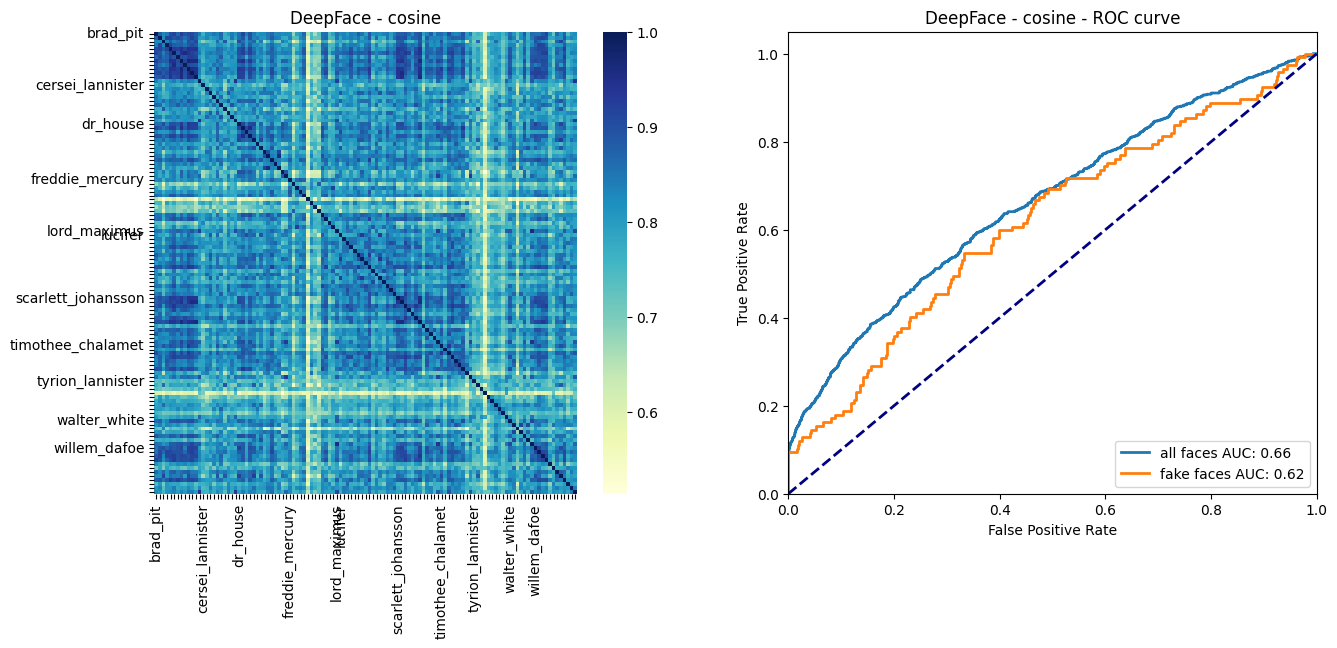

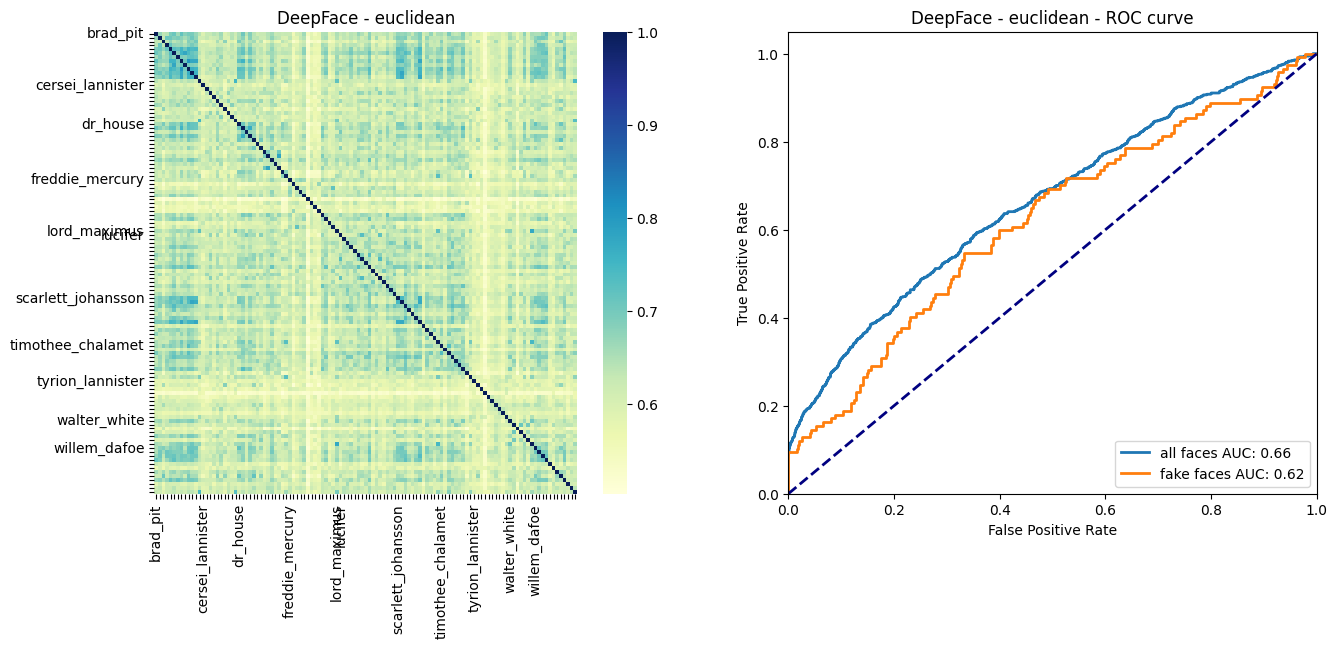

DeepID
(117, 160)


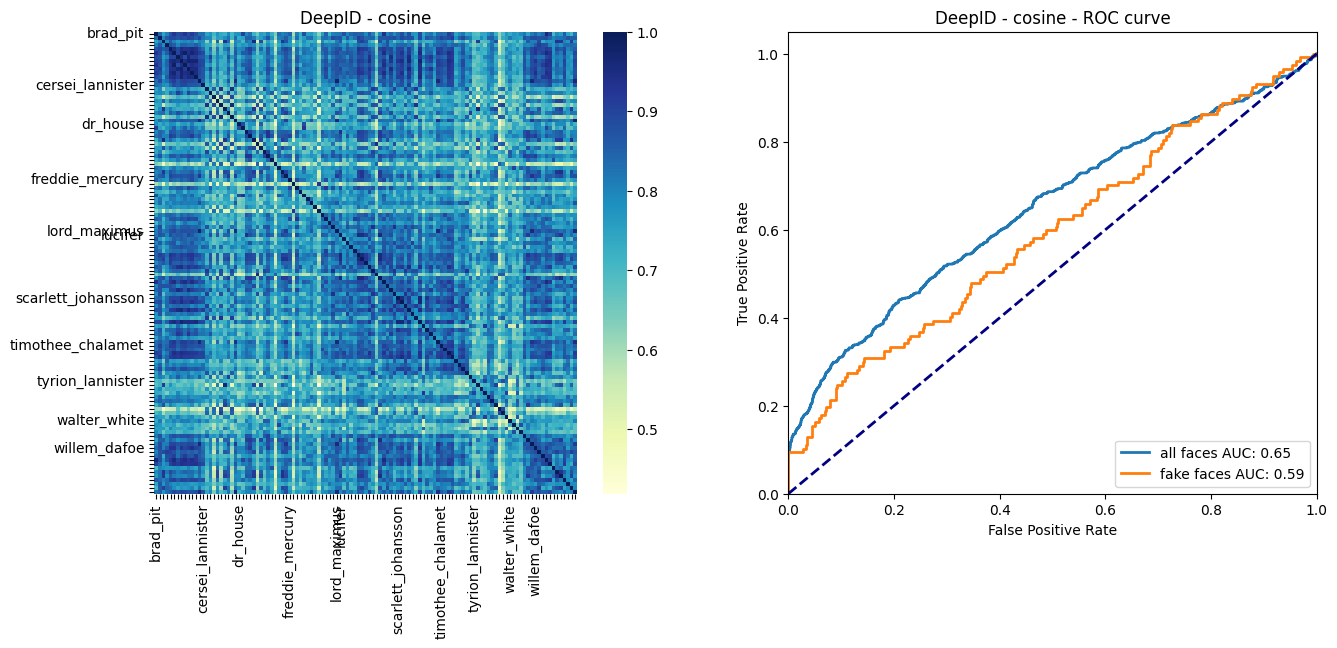

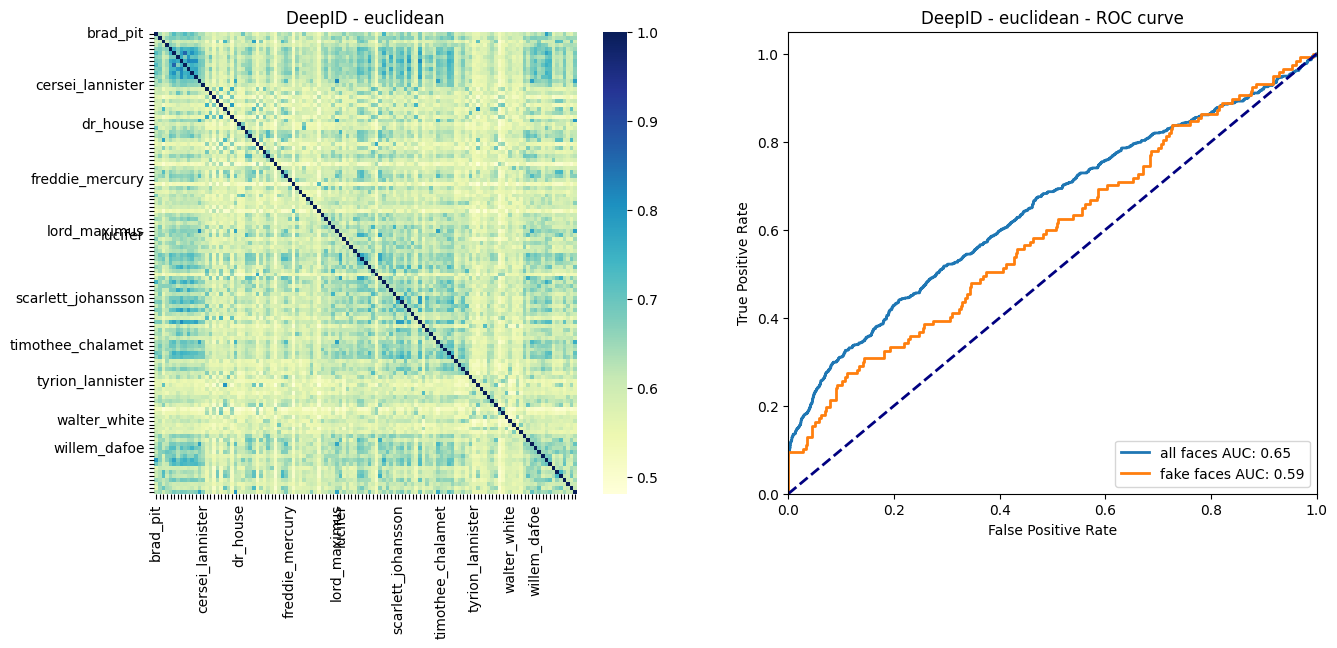

Dlib
(117, 128)


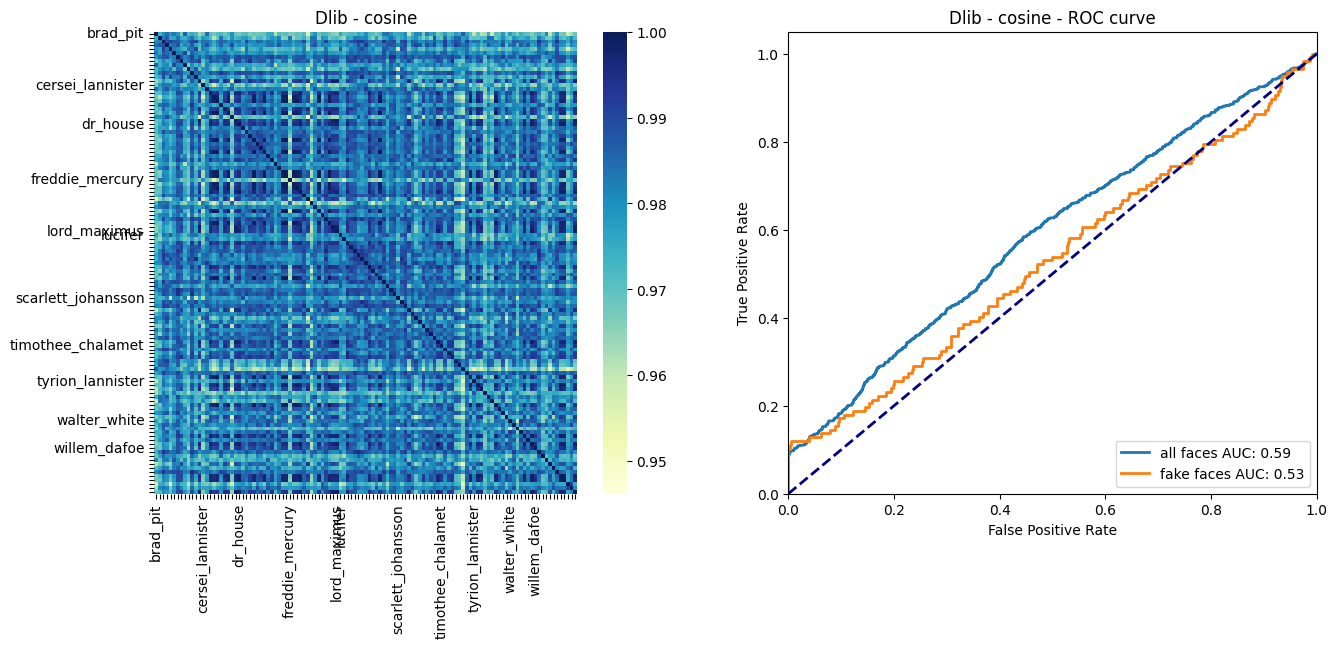

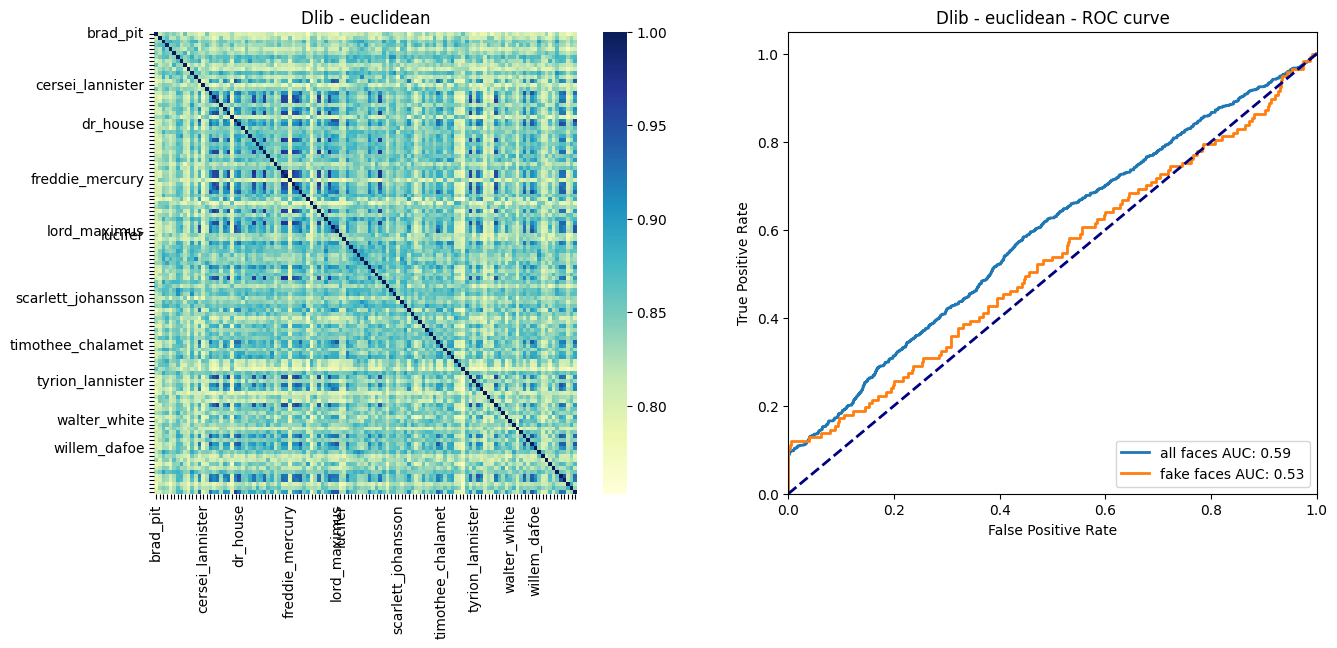

ArcFace
(117, 512)


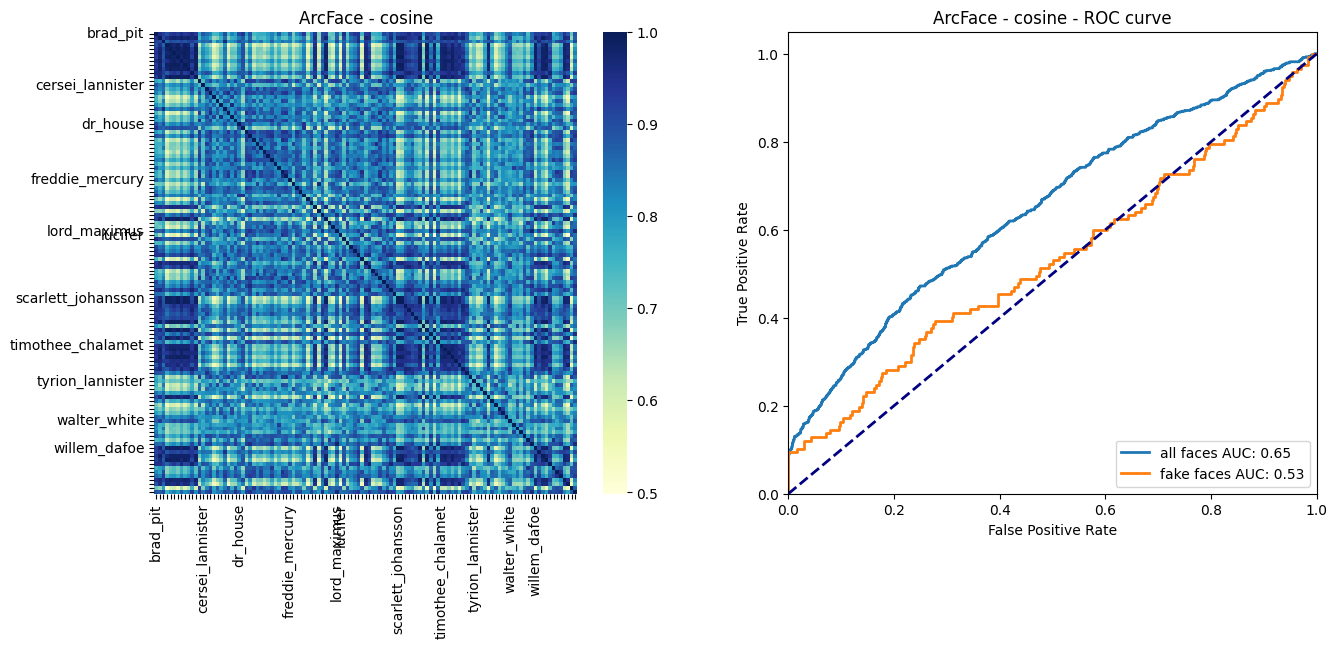

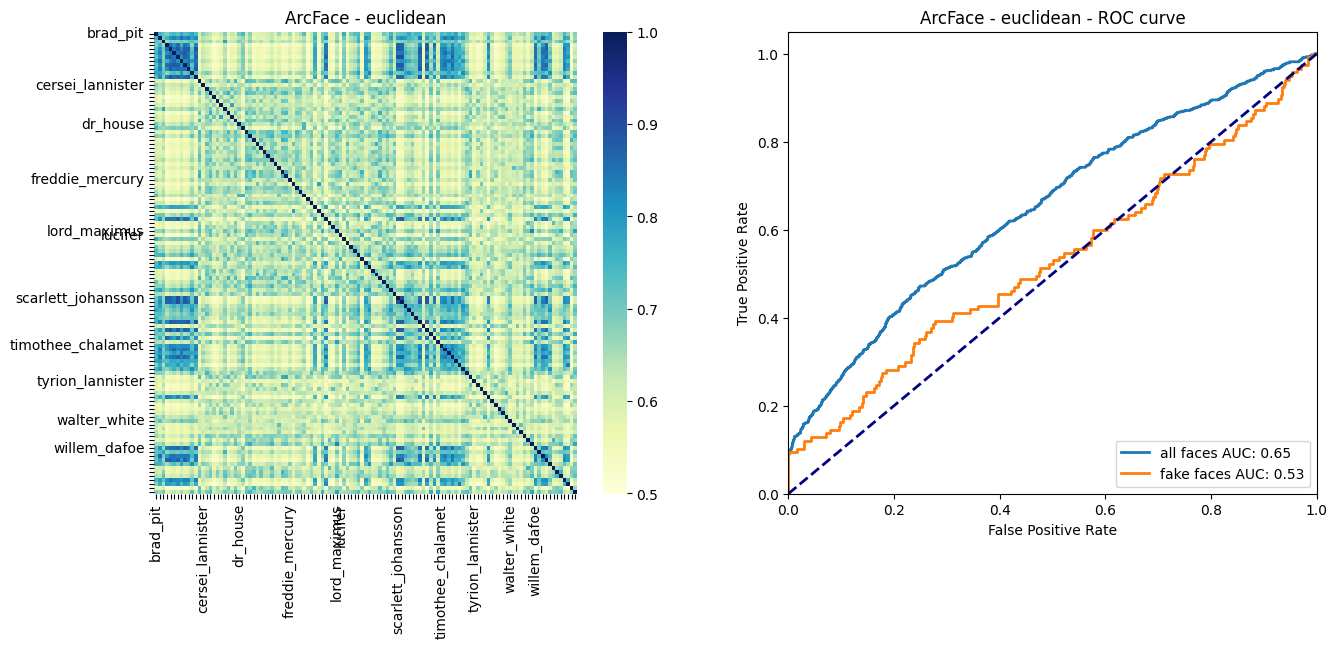

SFace
(117, 128)


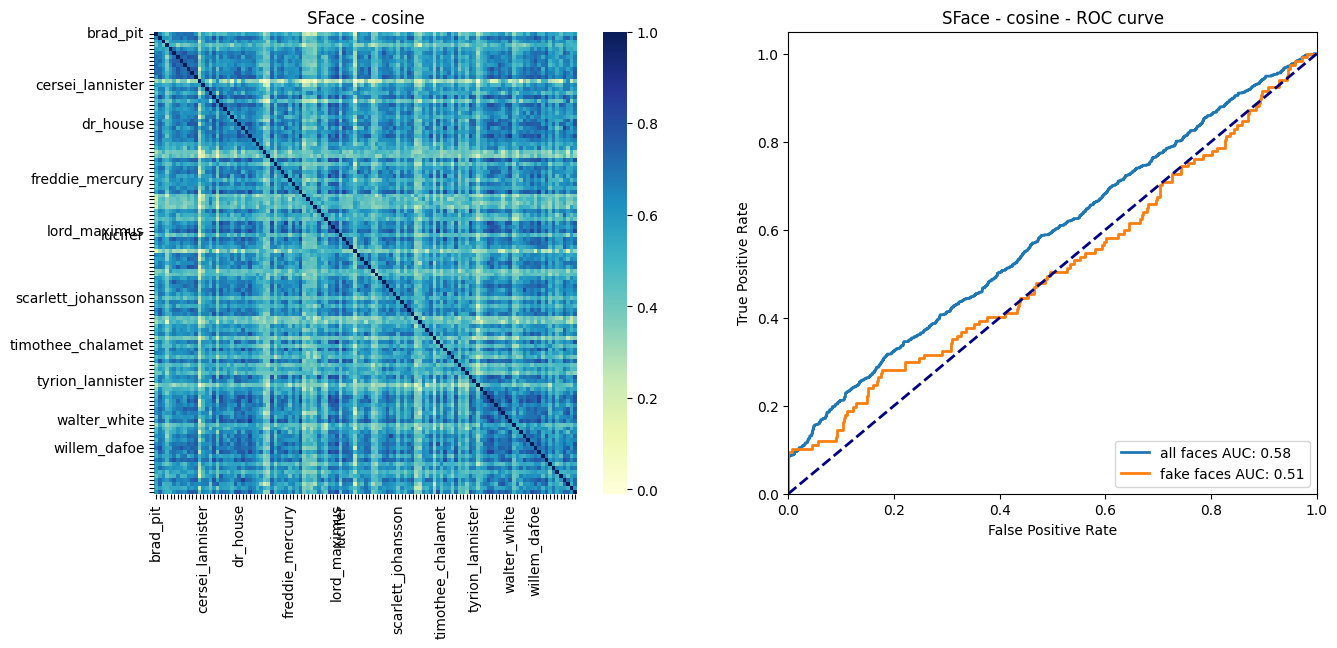

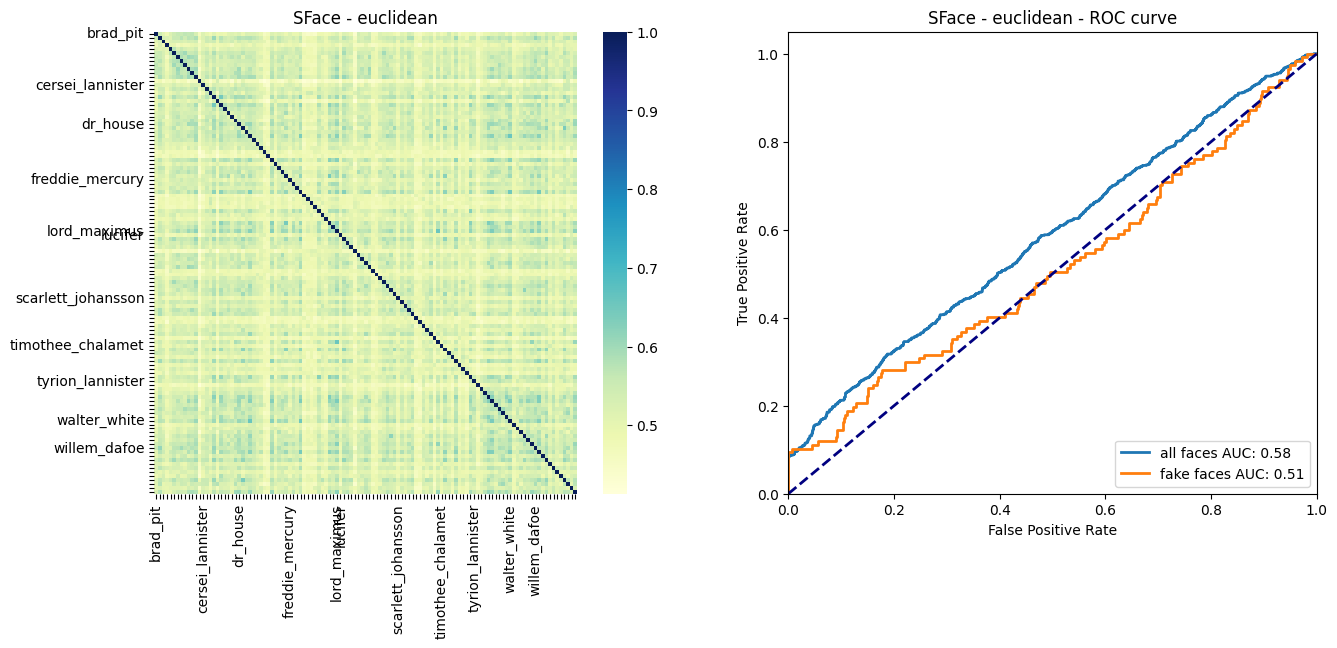

buffalo_s
(229, 512)


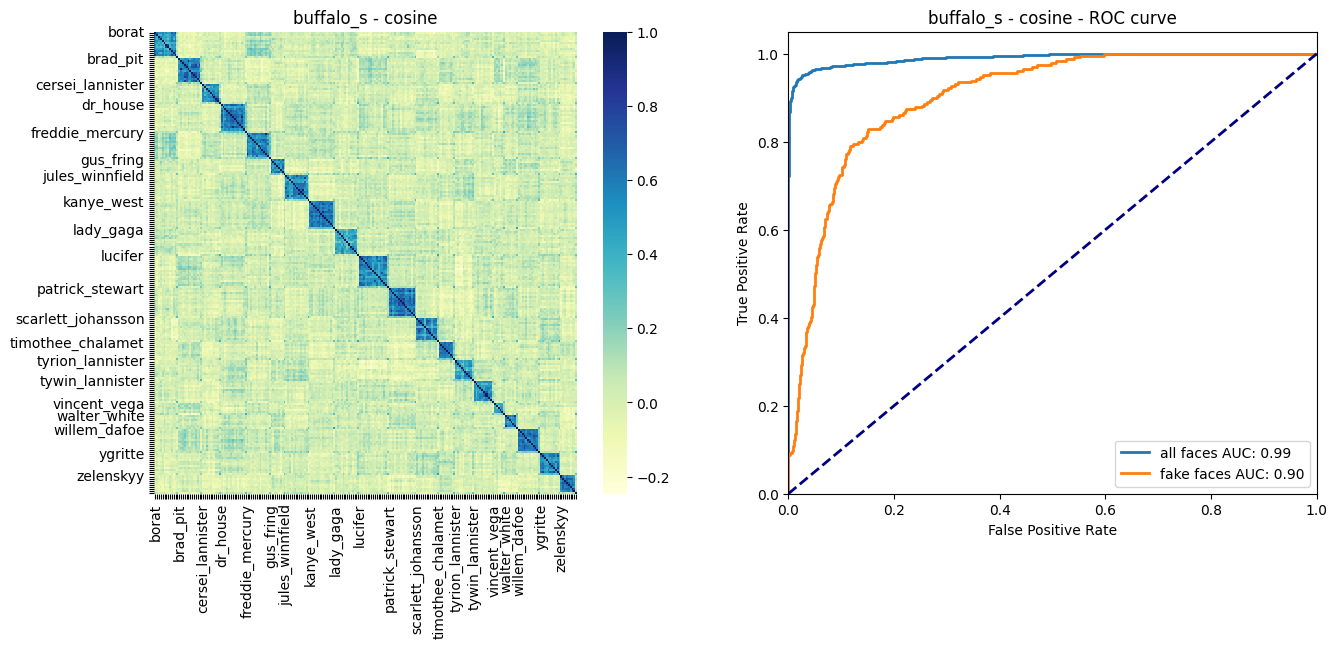

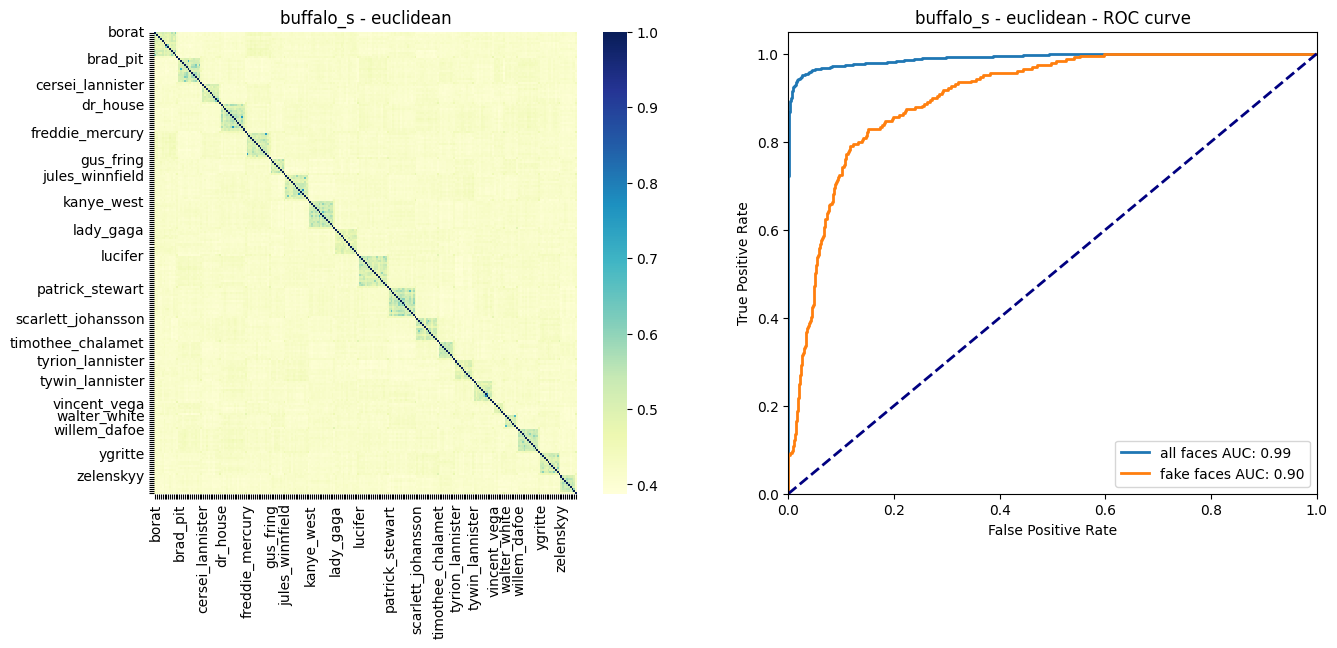

buffalo_sc
(229, 512)


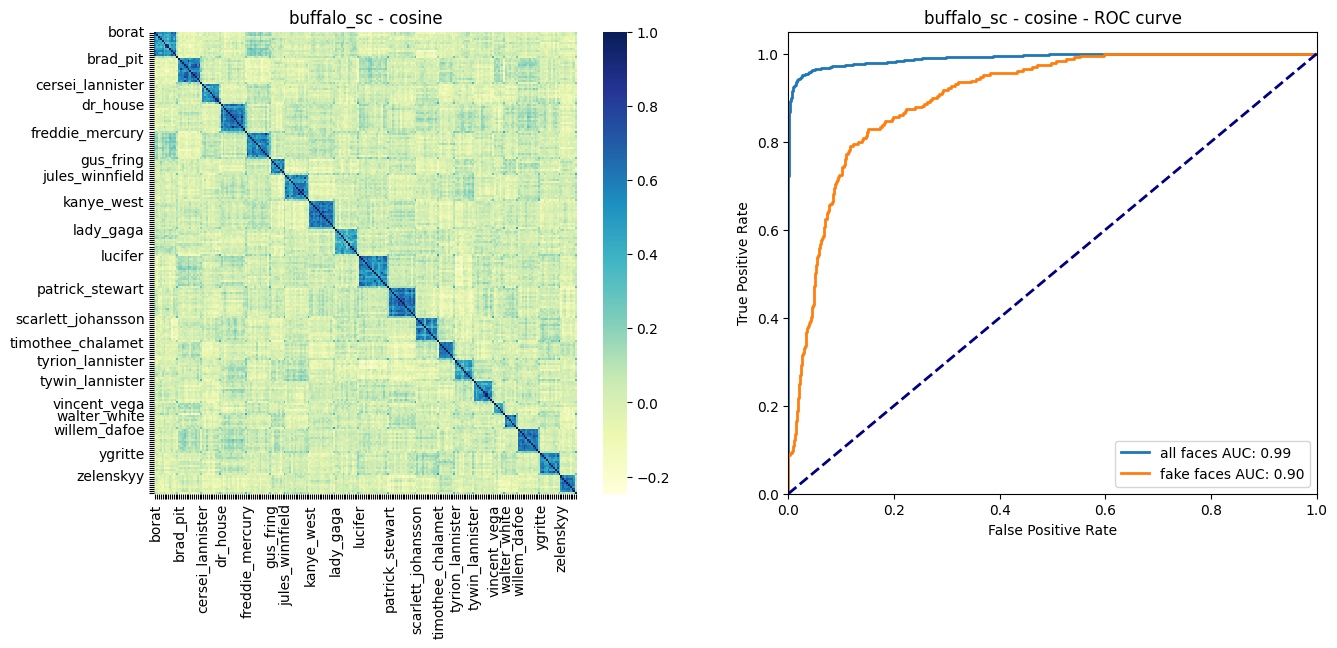

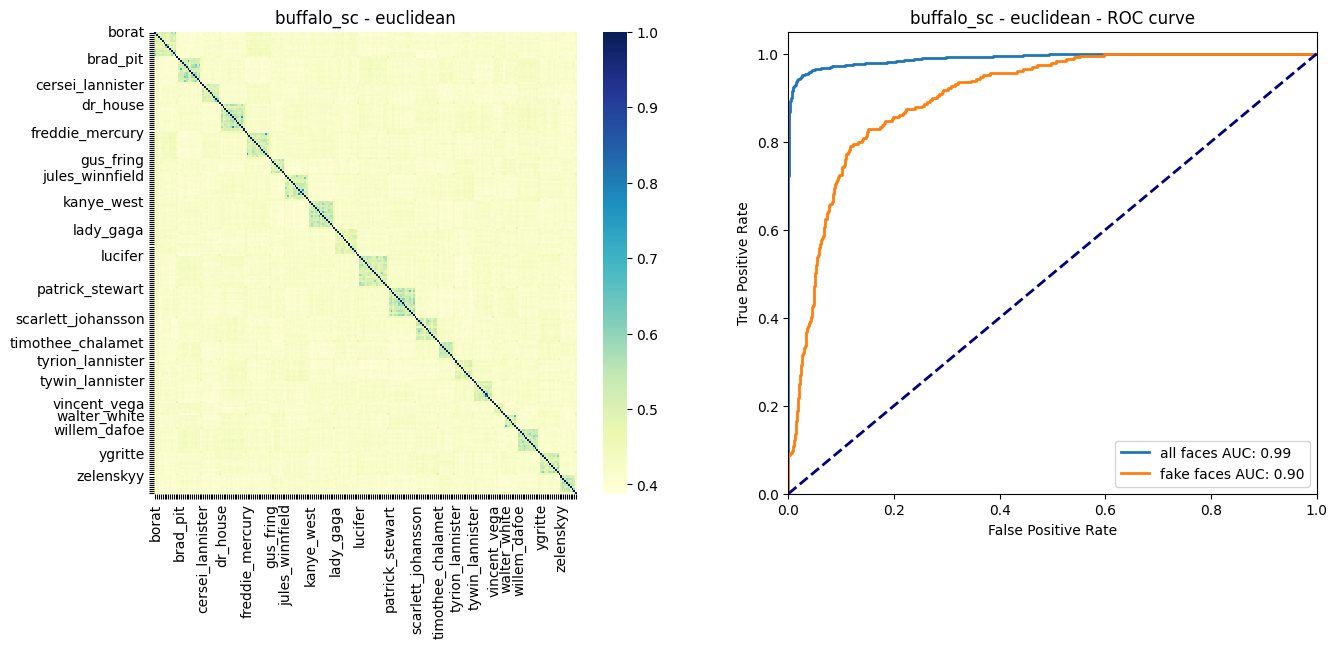

buffalo_m
(229, 512)


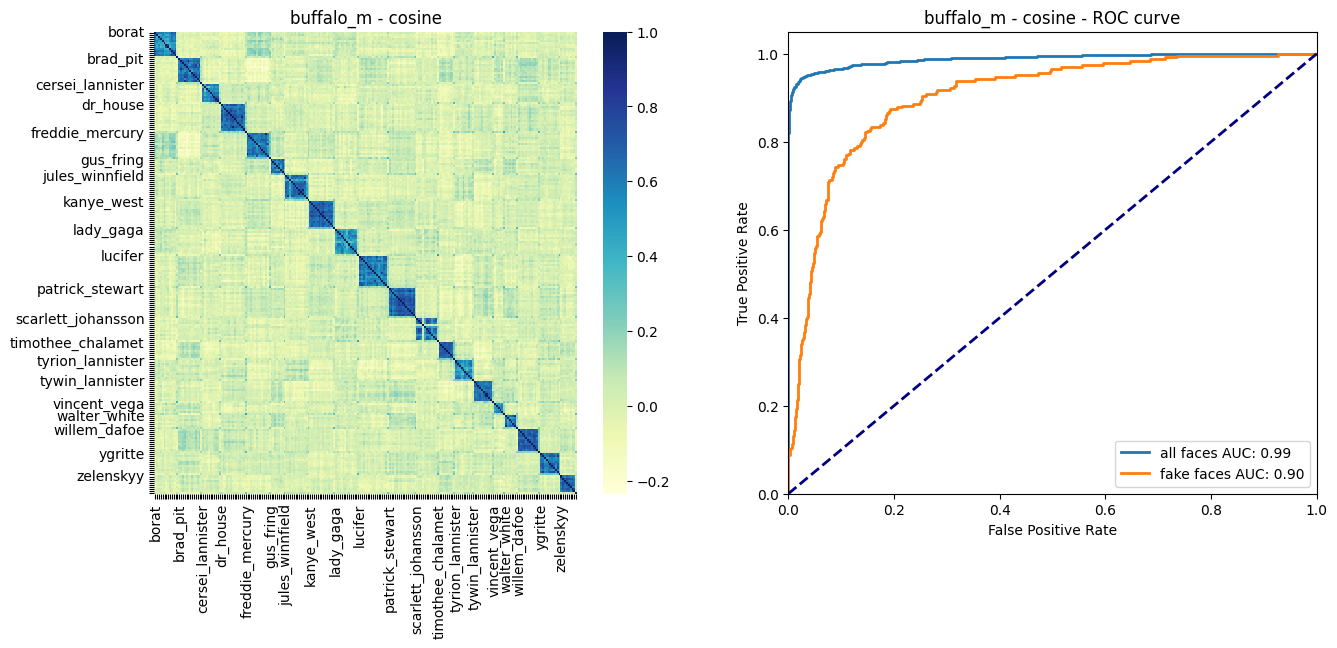

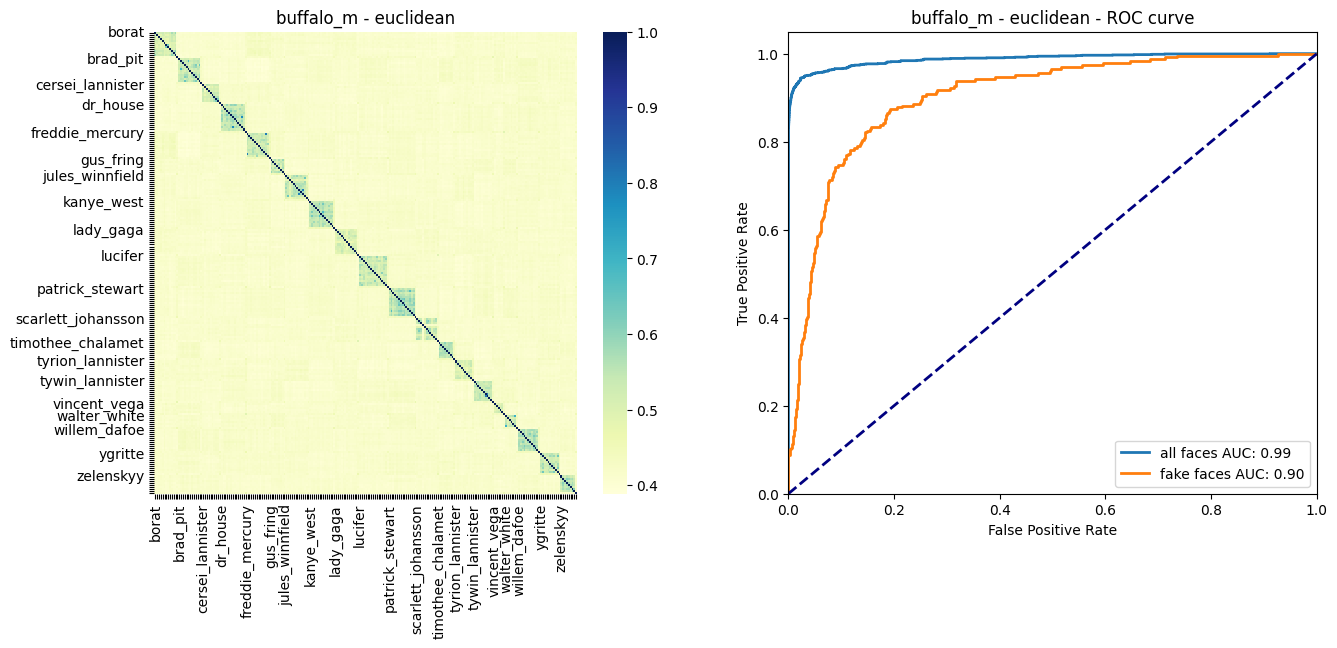

buffalo_l
(229, 512)


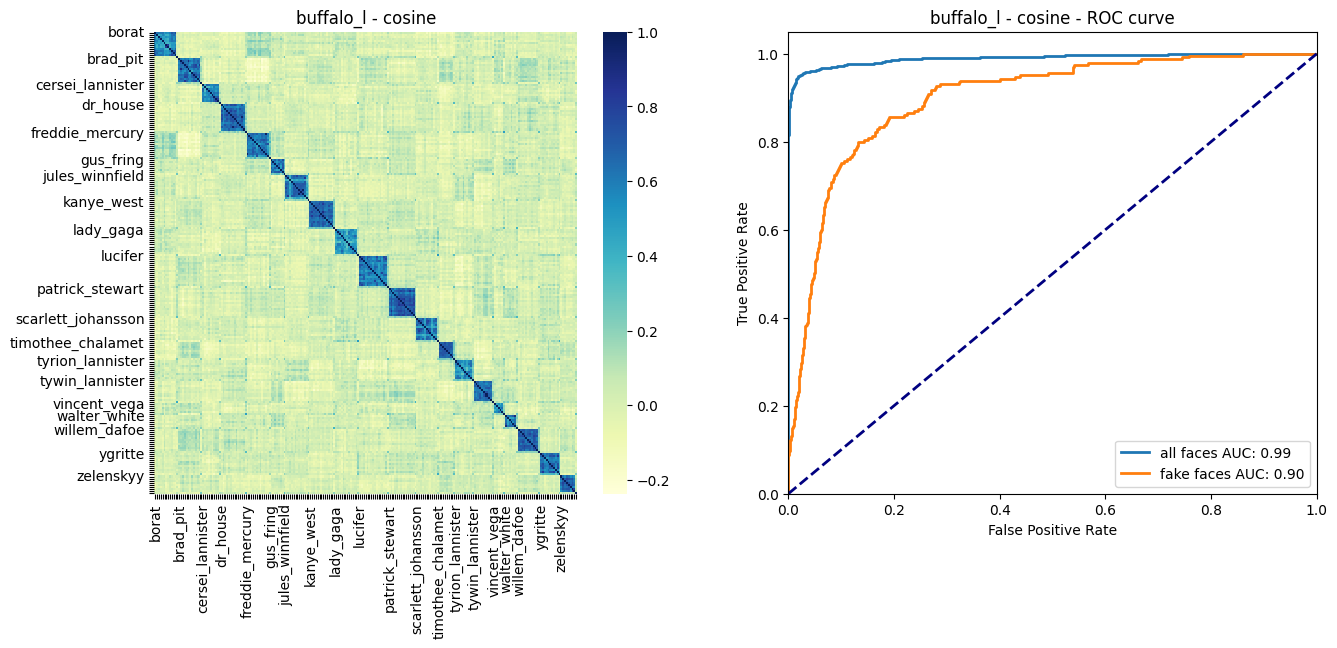

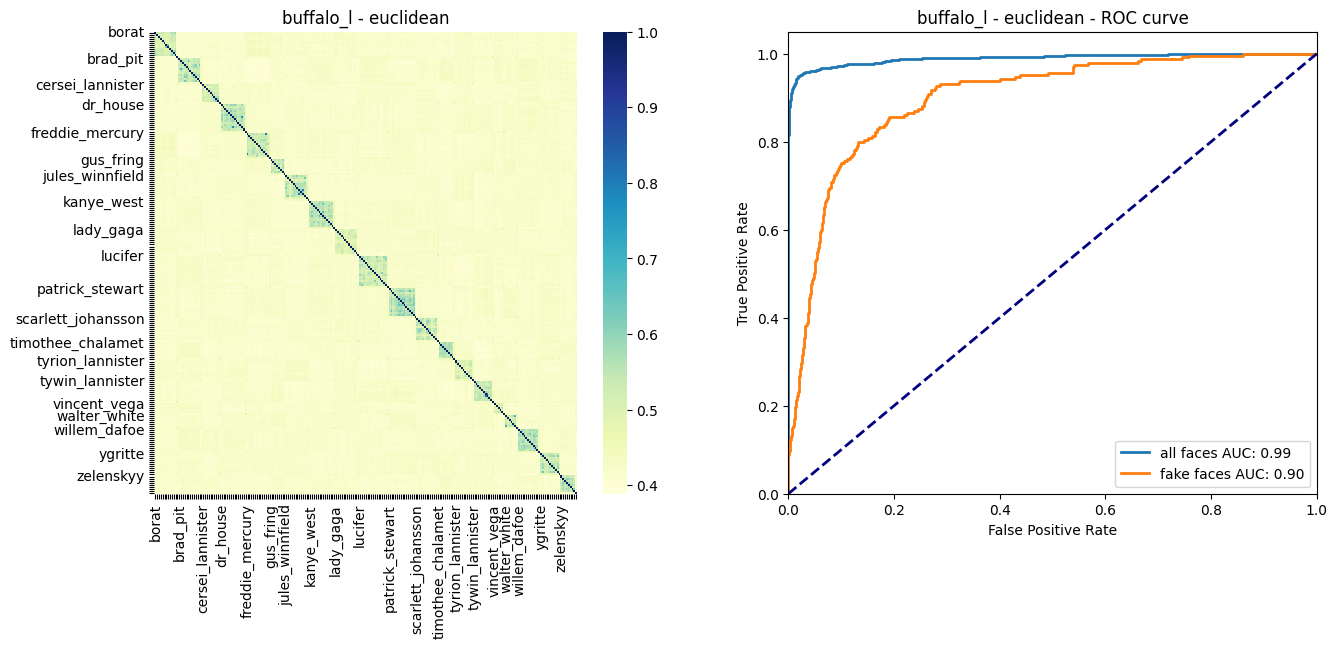

antelopev2
(229, 512)


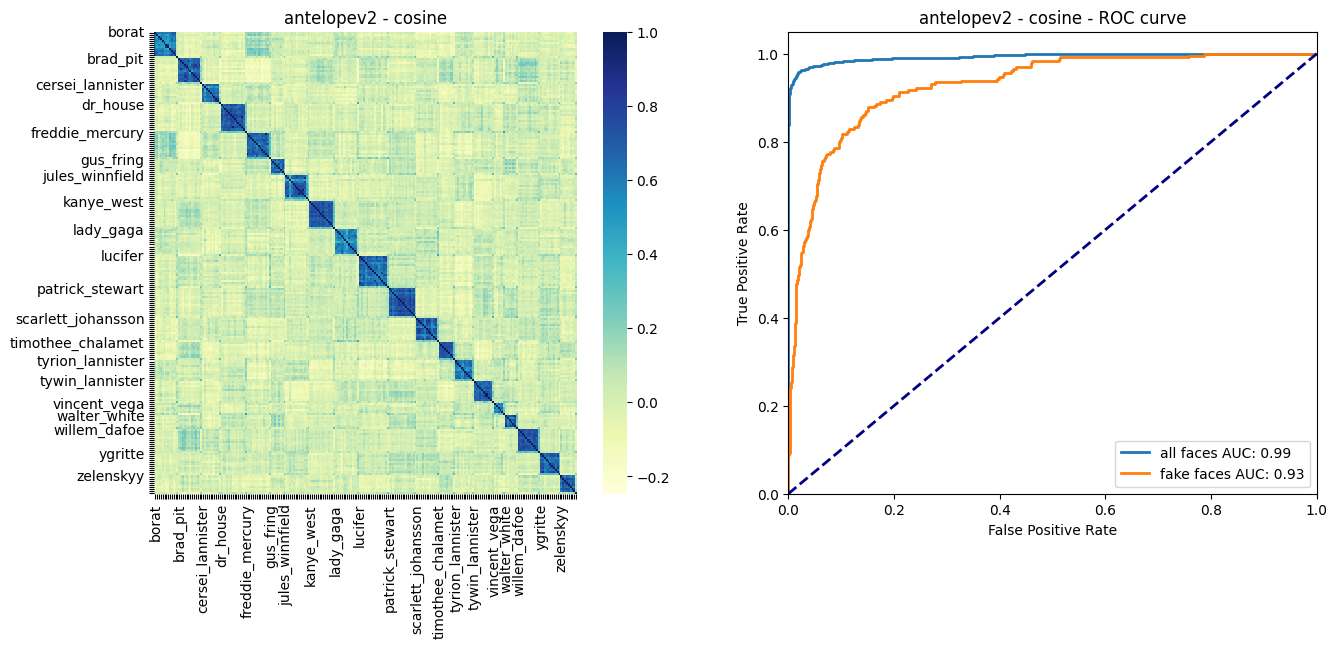

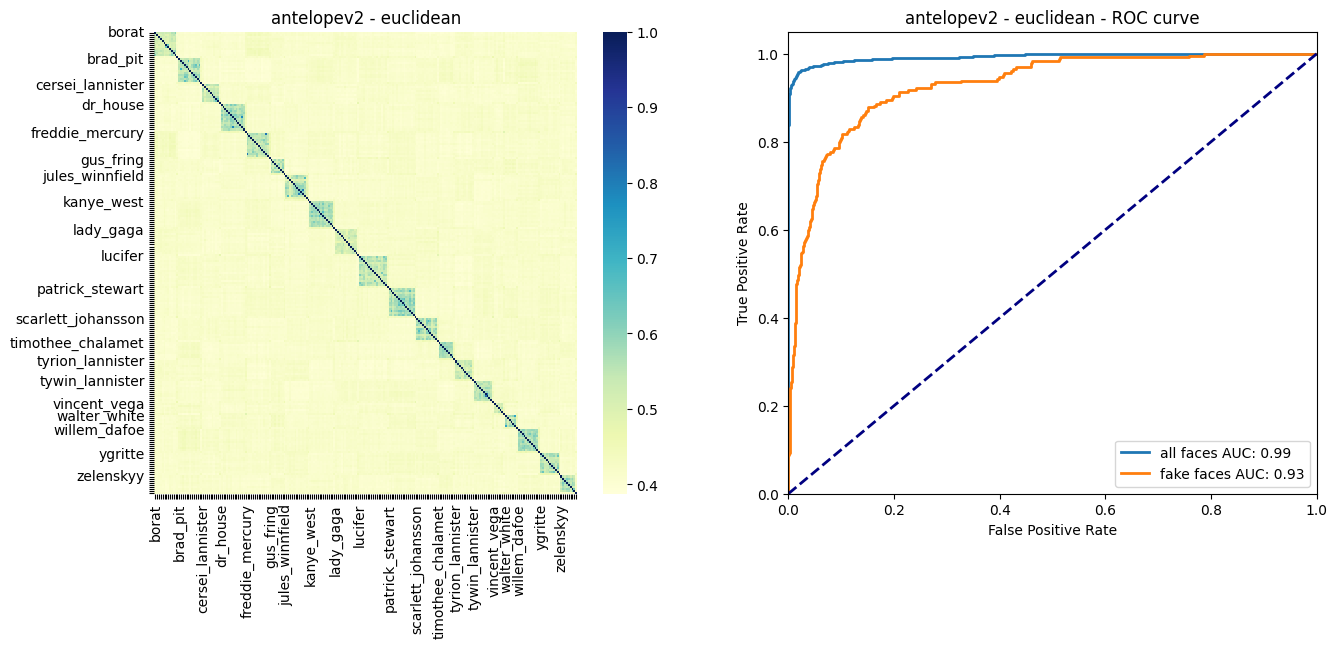

In [57]:
from deepface.commons.distance import findThreshold
import itertools as it
from sklearn.metrics import roc_curve, auc

# import cosine metric and euclidian metric from sklearn 
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances


for model_name, model_df in model2df.items():  
    model_df = model_df.sort_values(by=["labels", "is_fake"])
    embeddings_series = model_df["embeddings_l2norm"]
    print(model_name)
    X = np.array(embeddings_series.values.tolist())
    print(X.shape)
    metric2distances = {}
    for metric_name, metric_fun in zip(["cosine", "euclidean"], [cosine_similarity, euclidean_distances]):
        distances = embeddings_series.apply(lambda x: metric_fun(X, x.reshape(1, -1)))
        d = np.array(distances.values.tolist()).squeeze(-1)
        if metric_name == "euclidean":
            d = 1 / (1 + d)
        metric2distances[metric_name] = d
    
    labels = []
    for l in model_df["labels"]:
        if l not in labels:
            labels.append(l)
        else:
            labels.append("")
    
    for metric_name, d in metric2distances.items():
        fig, axs = plt.subplots(1, 2, figsize=(15, 6))
        sns.heatmap(
            d,
            xticklabels=labels,
            yticklabels=labels,
            cmap="YlGnBu",
            ax=axs[0]
        )
        axs[0].set_title(f"{model_name} - {metric_name}")

        # draw roc curve for all labels
        y = [1 if l1 == l2 else 0 for l1, l2 in it.product(model_df["labels"], model_df["labels"])]
        y_score = d.flatten()
        fpr, tpr, _ = roc_curve(y, y_score)
        roc_auc = auc(fpr, tpr)
        axs[1].plot(fpr, tpr, lw=2, label=f"all faces AUC: {roc_auc:.2f}")


        fake_mask = model_df["is_fake"] == 1
        y_fake = [1 if l1 == l2 else 0 for l1, l2 in it.product(model_df[fake_mask]["labels"], model_df["labels"])]
        y_score_fake = d[fake_mask].flatten()
        fpr, tpr, _ = roc_curve(y_fake, y_score_fake)
        roc_auc = auc(fpr, tpr)
        axs[1].plot(fpr, tpr, lw=2, label=f"fake faces AUC: {roc_auc:.2f}")

        axs[1].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        axs[1].set_xlim([0.0, 1.0])
        axs[1].set_ylim([0.0, 1.05])
        axs[1].set_xlabel('False Positive Rate')
        axs[1].set_ylabel('True Positive Rate')
        axs[1].set_title(f"{model_name} - {metric_name} - ROC curve")
        axs[1].legend(loc="lower right")
        plt.show()

# Map embeddings onto 2D plane

## t-SNE

In [10]:
from sklearn.manifold import TSNE

model2tsne = {}
for model, model_df in model2df.items():
    X = np.array(model_df["embeddings_l2norm"].values.tolist())

    tsne = TSNE(n_components=2, random_state=0, perplexity=15, n_iter=2000, metric="cosine")
    embeddings_tsne = tsne.fit_transform(X)
    model2tsne[model] = embeddings_tsne

VGG-Face
OpenFace
Facenet
Facenet512
DeepFace
DeepID
Dlib
ArcFace
SFace
buffalo_s
buffalo_sc
buffalo_m
buffalo_l
antelopev2


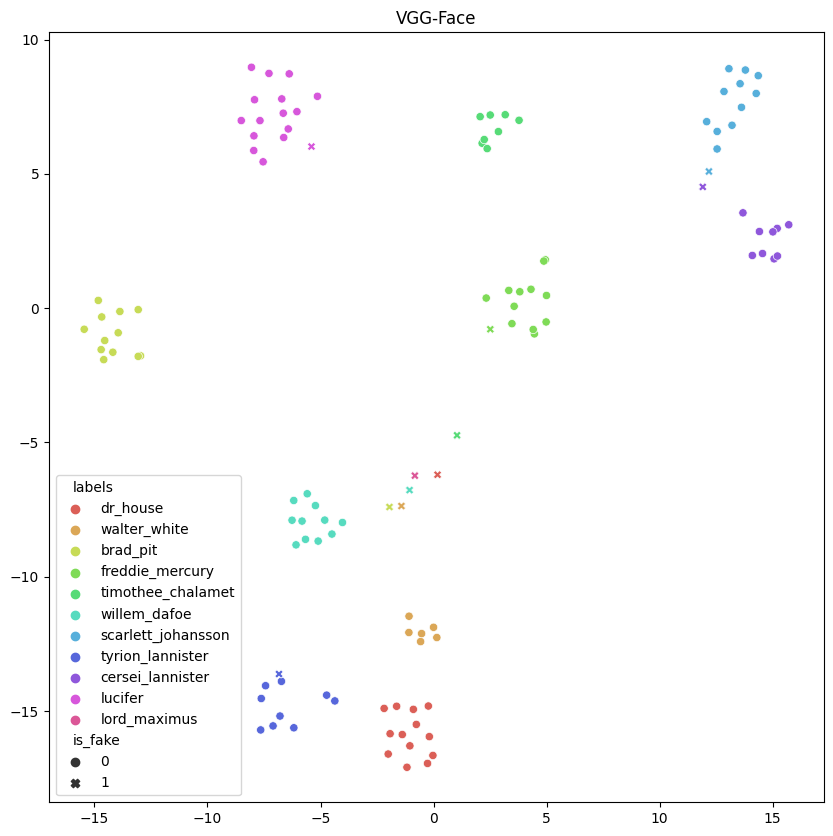

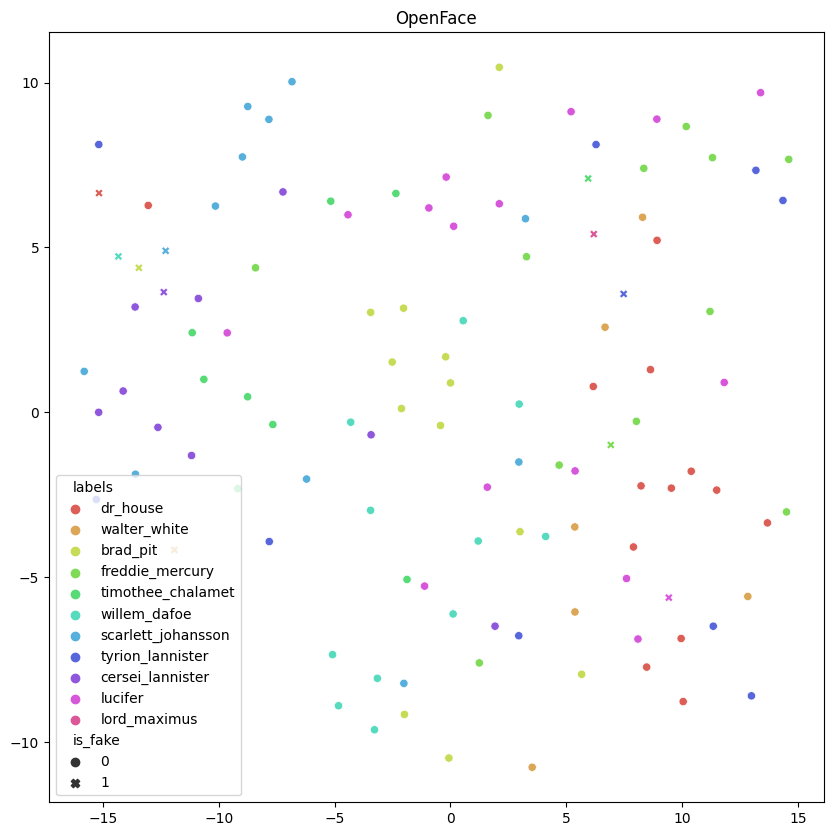

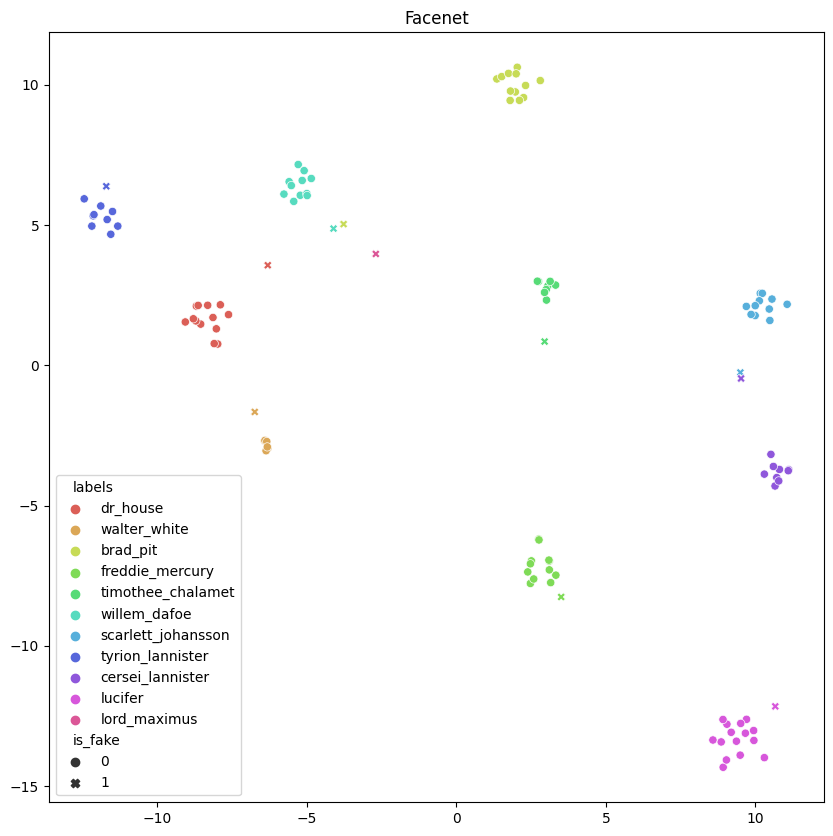

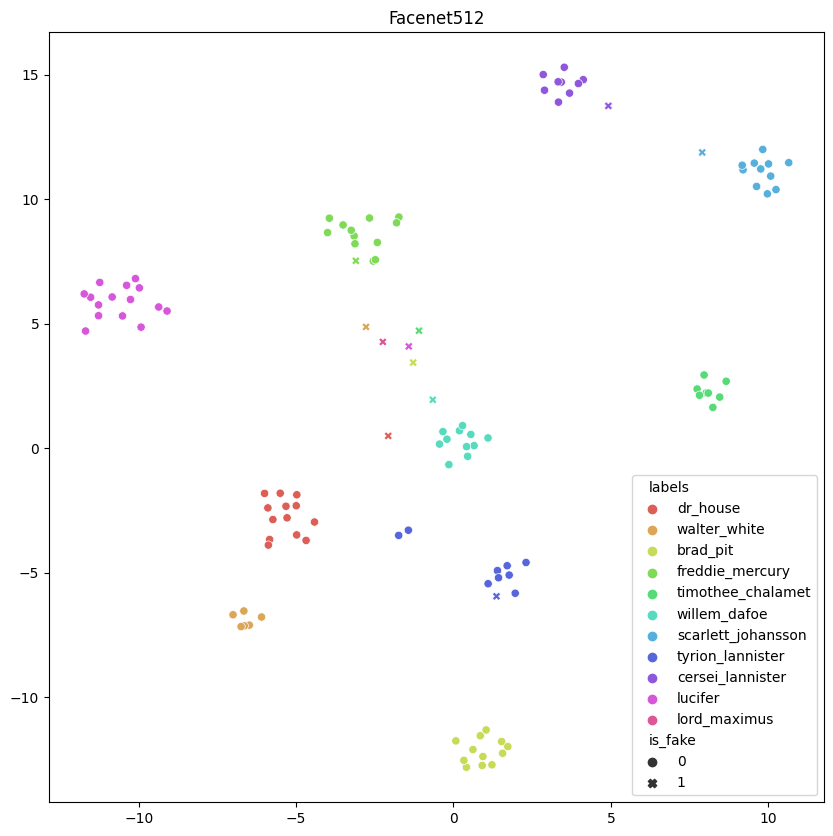

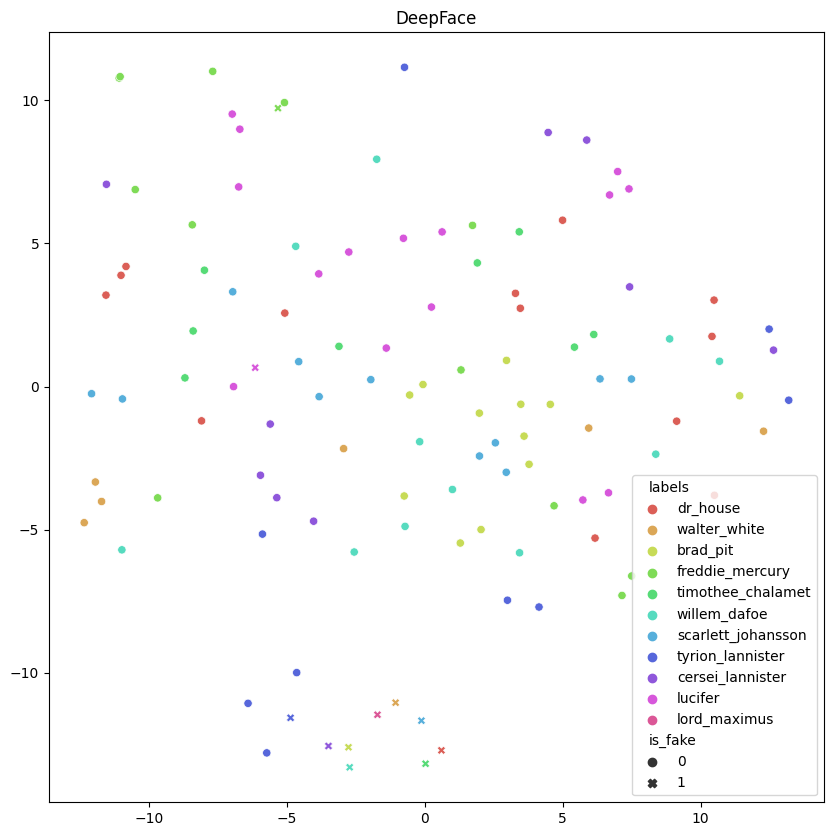

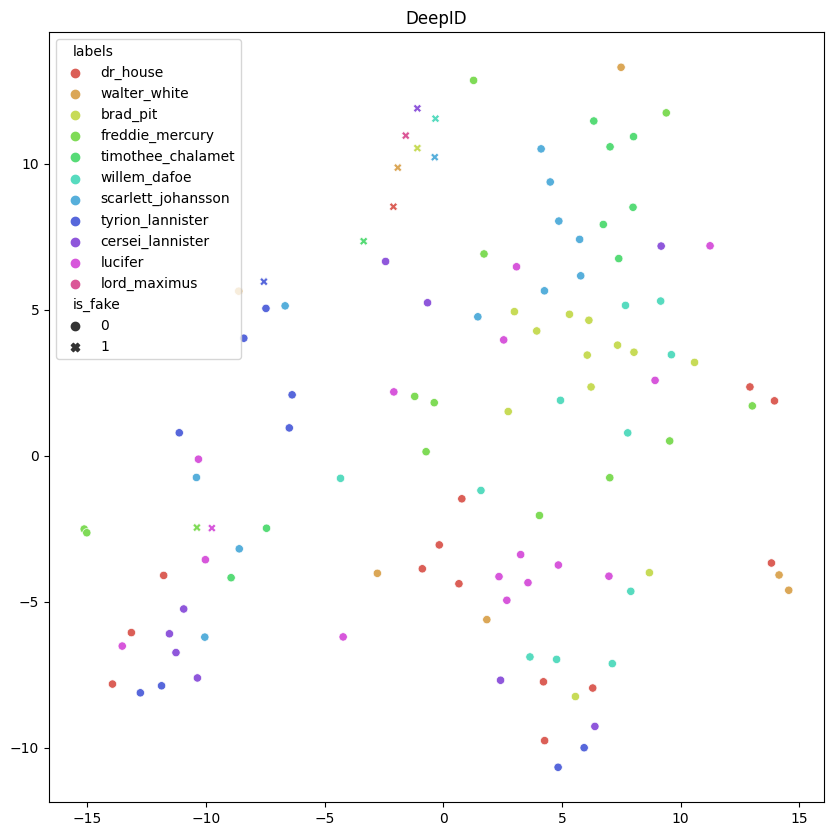

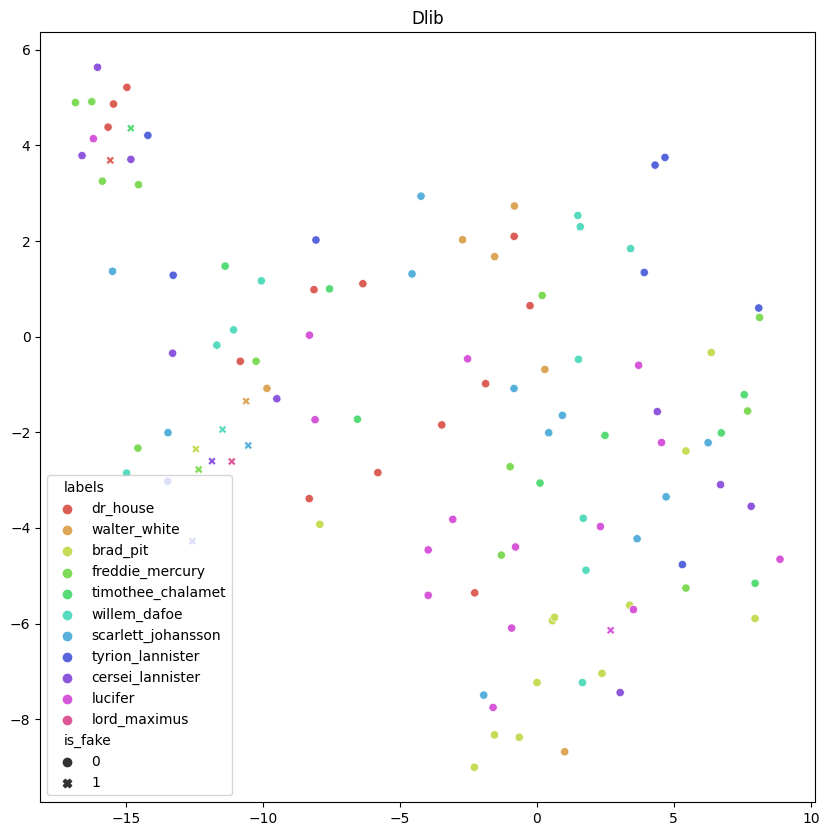

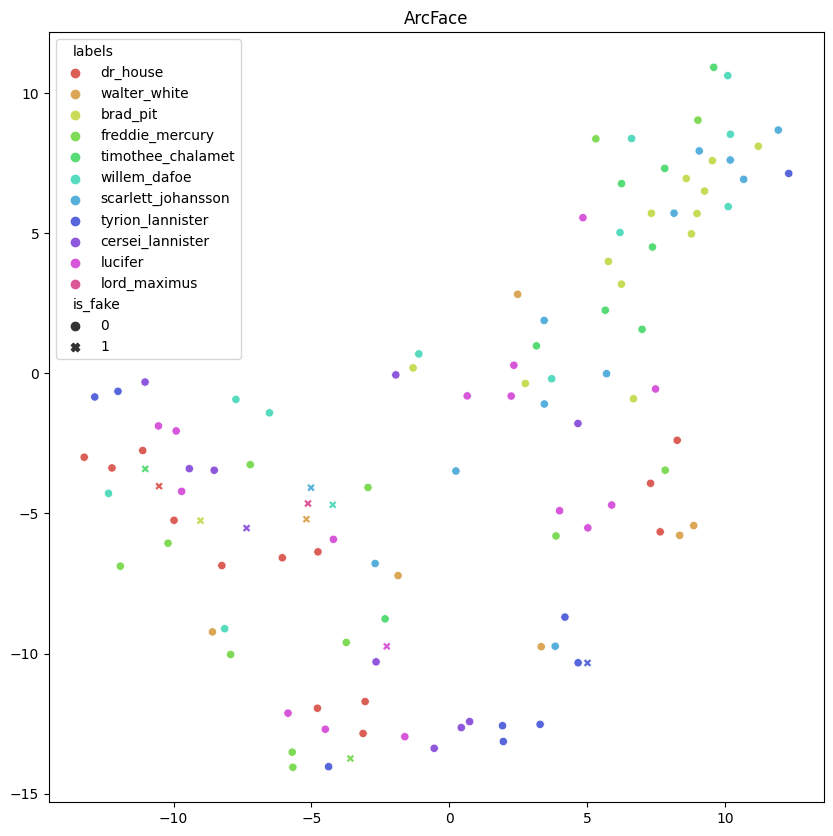

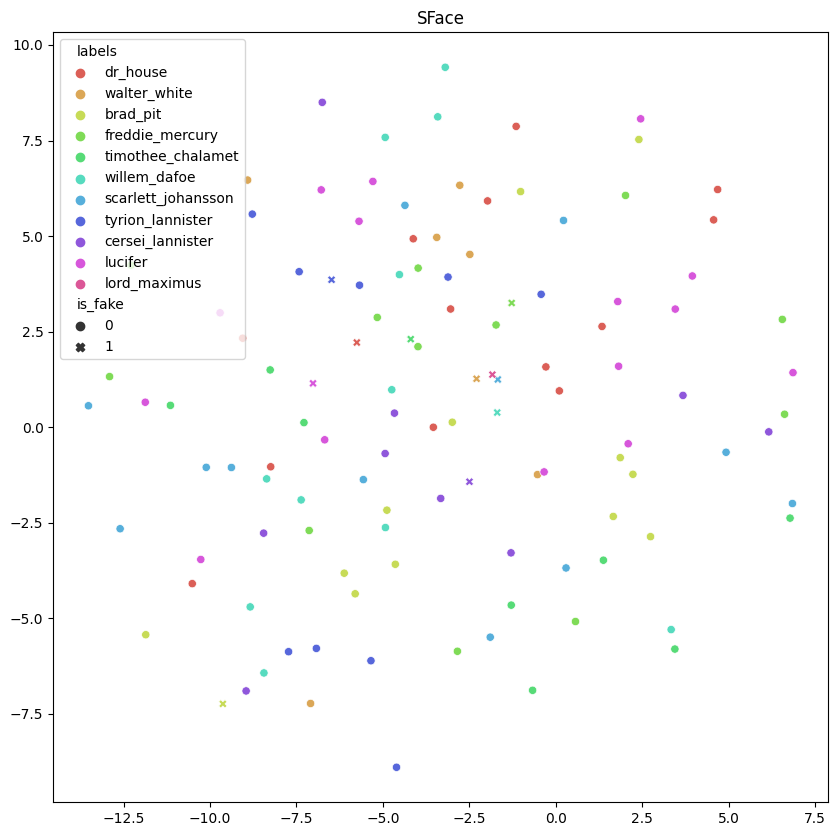

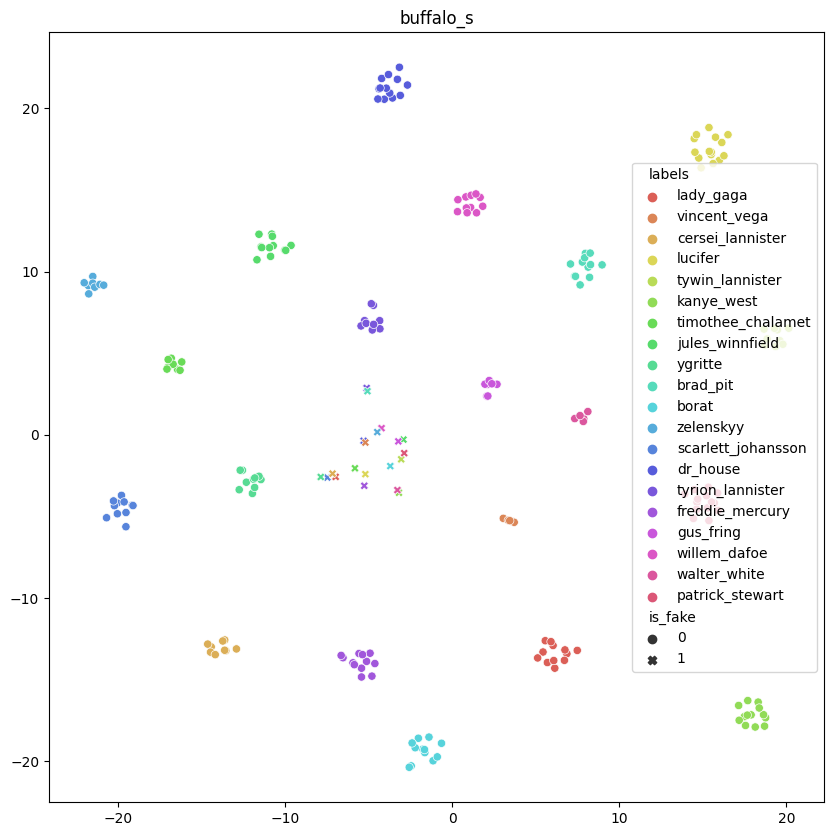

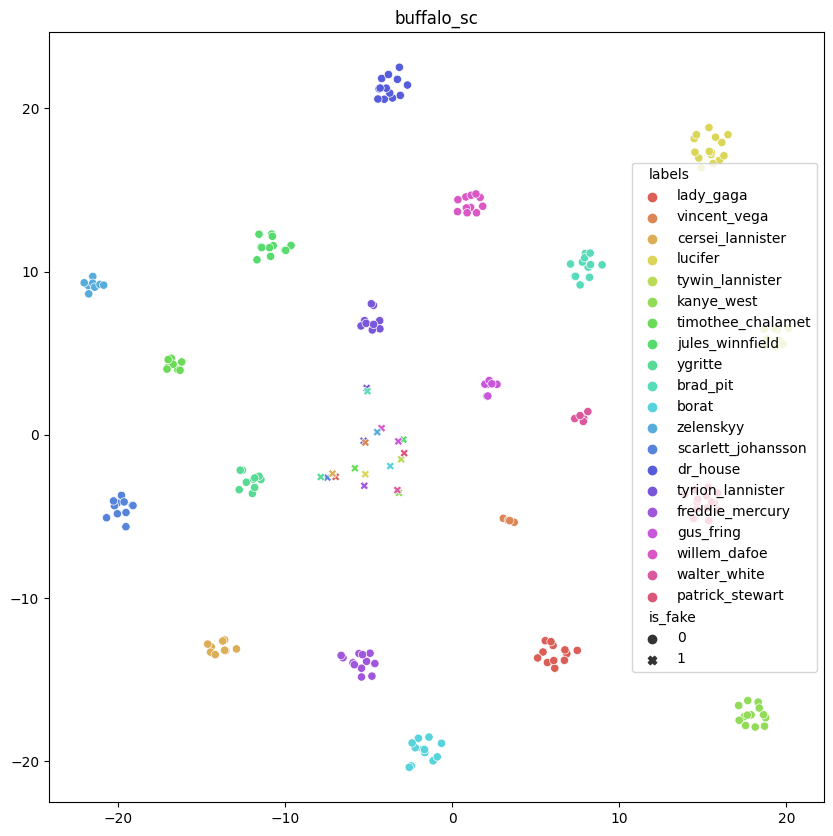

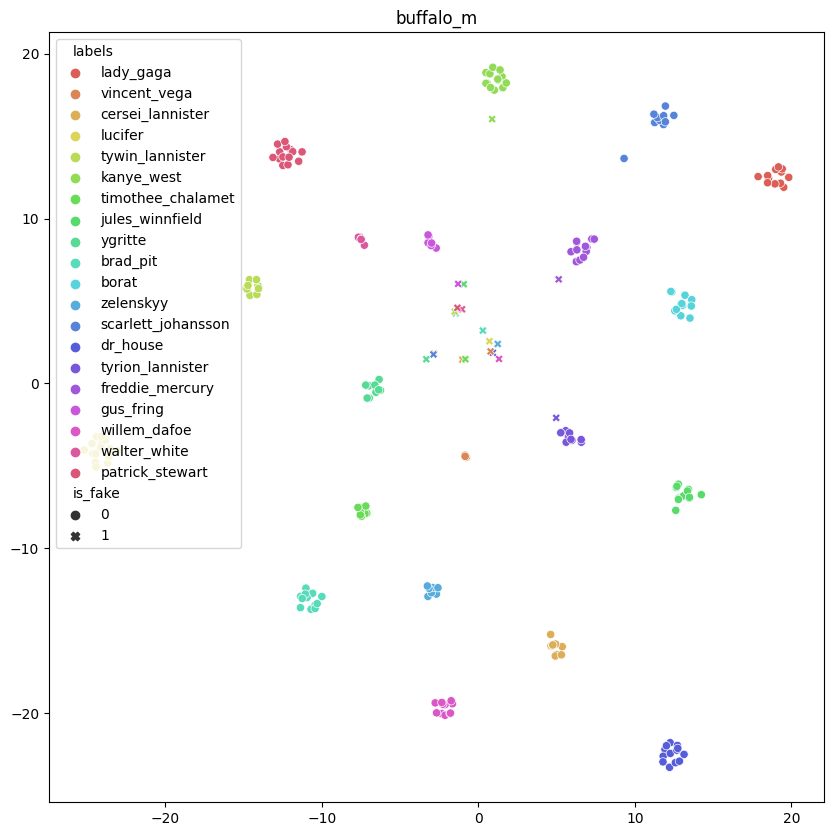

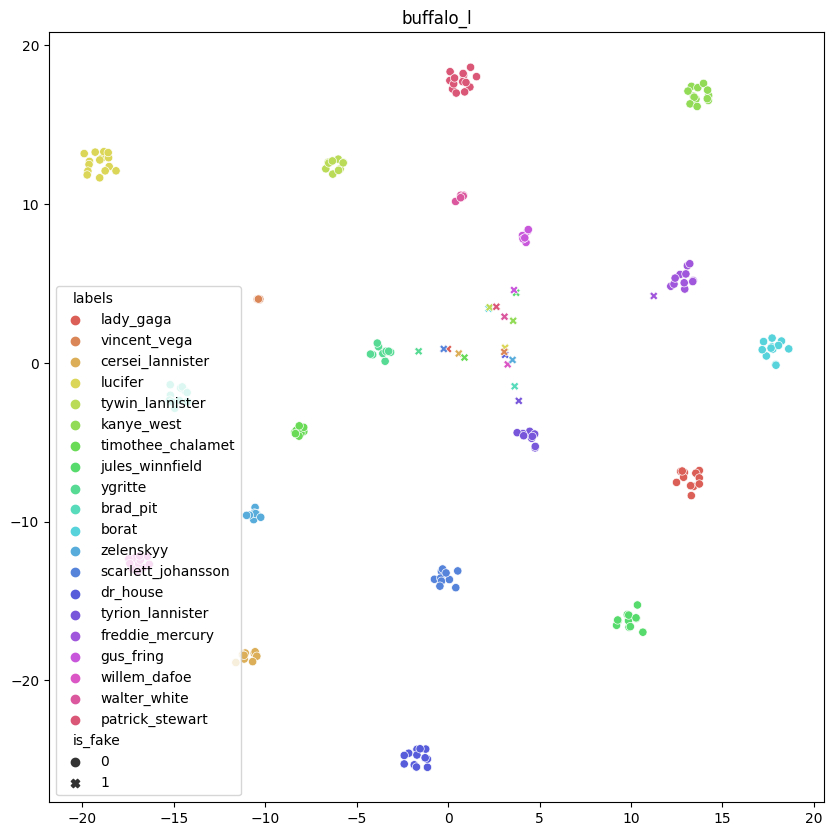

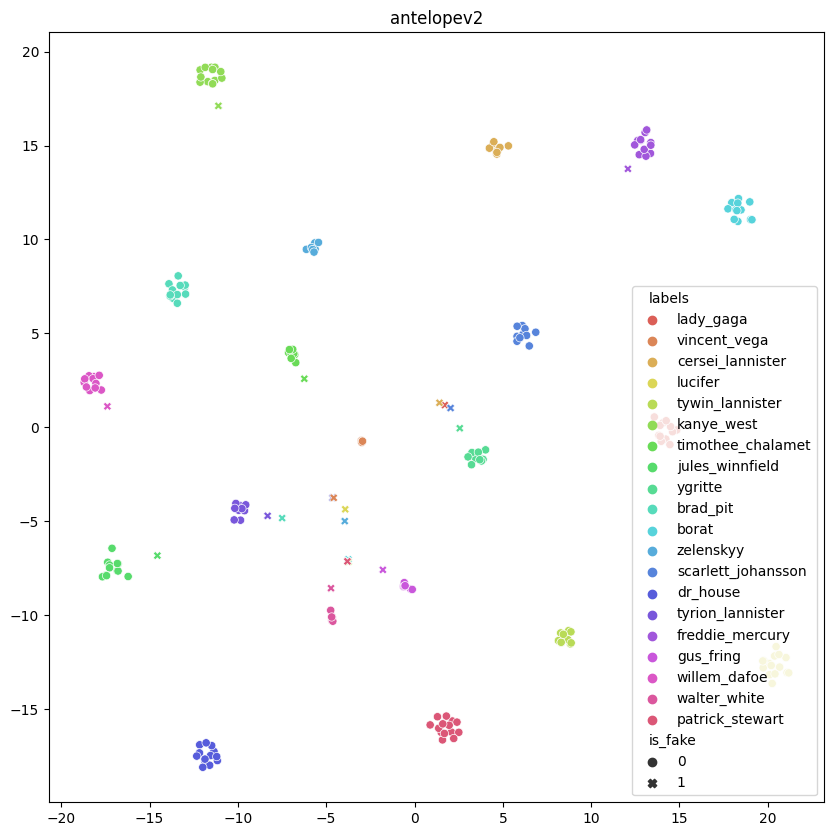

In [11]:
for model, tsne_mapping in model2tsne.items():
    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        x=tsne_mapping[:,0], y=tsne_mapping[:,1],
        hue=model2df[model]["labels"],
        style=model2df[model]["is_fake"],
        palette=sns.color_palette("hls", len(model2df[model]["labels"].unique()))
    )
    plt.title(model)
    plt.show()

## UMAP

In [ ]:
from umap import UMAP

model2umap= {}
for model, model_dict in embeddings.items():
    model_df = dict2df(model_dict)
    X = np.array(model_df["embeddings"].values.tolist())

    umap = UMAP(n_components=2, random_state=0, n_neighbors=5, min_dist=0.1, metric='cosine')
    embeddings_umap = umap.fit_transform(X)

    model2umap[model] = embeddings_umap
    

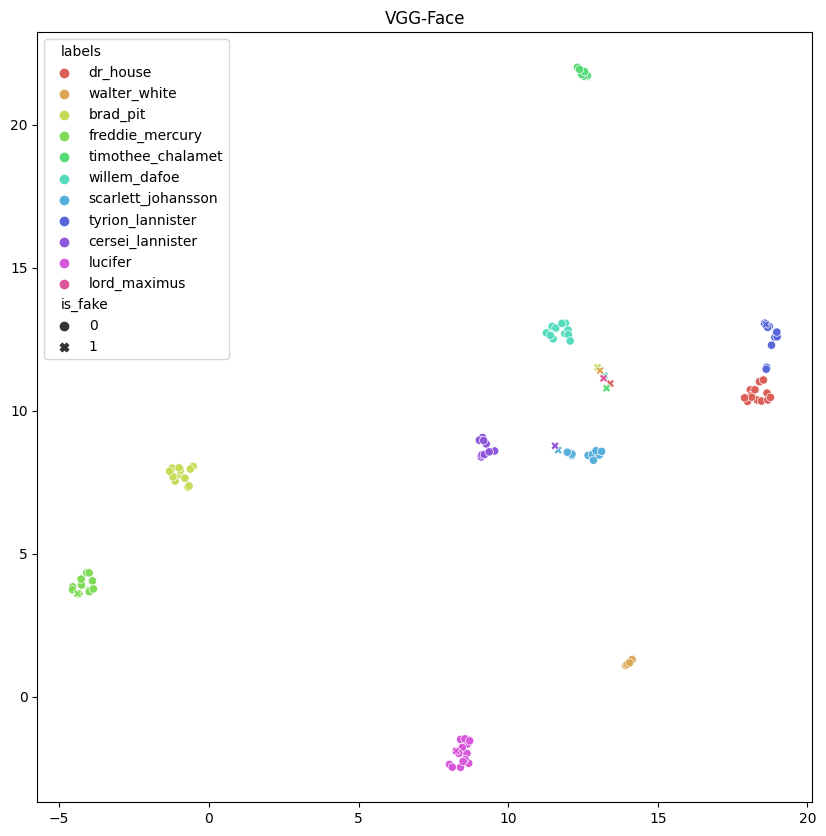

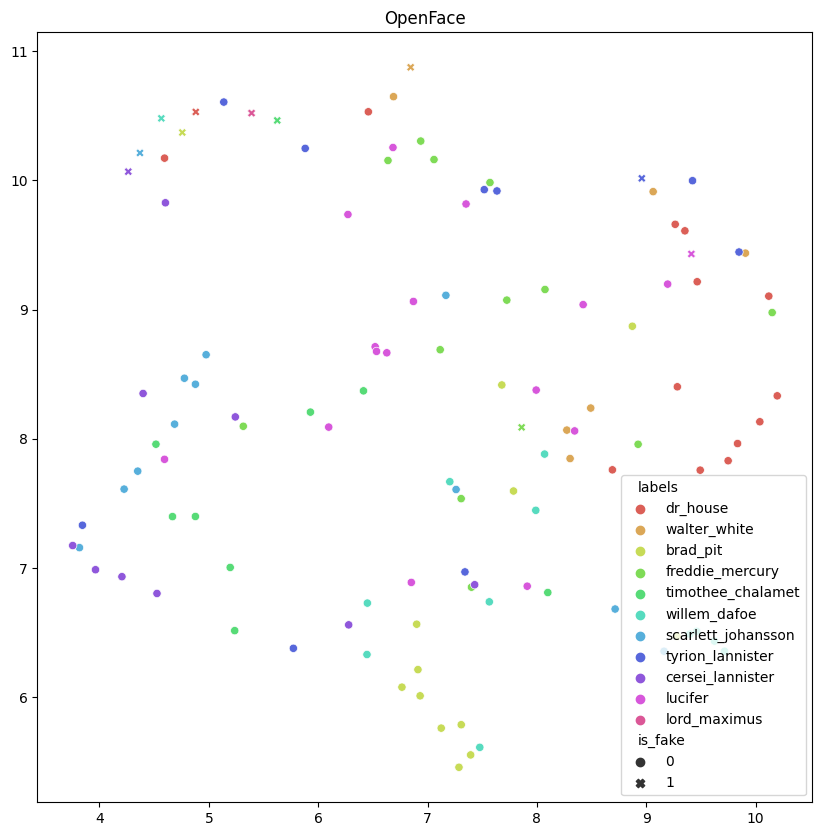

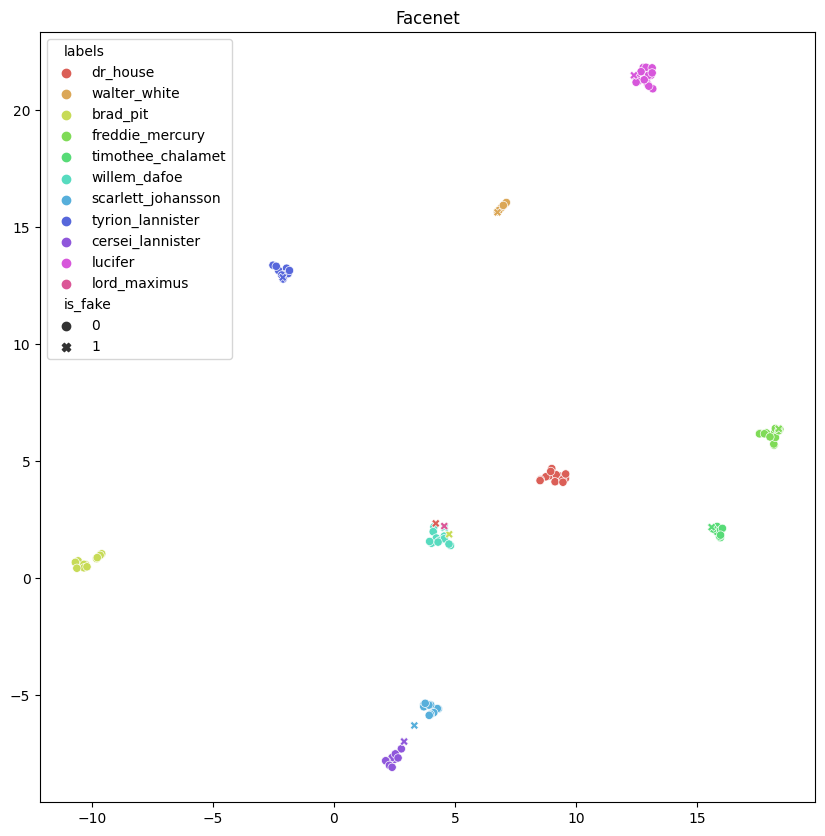

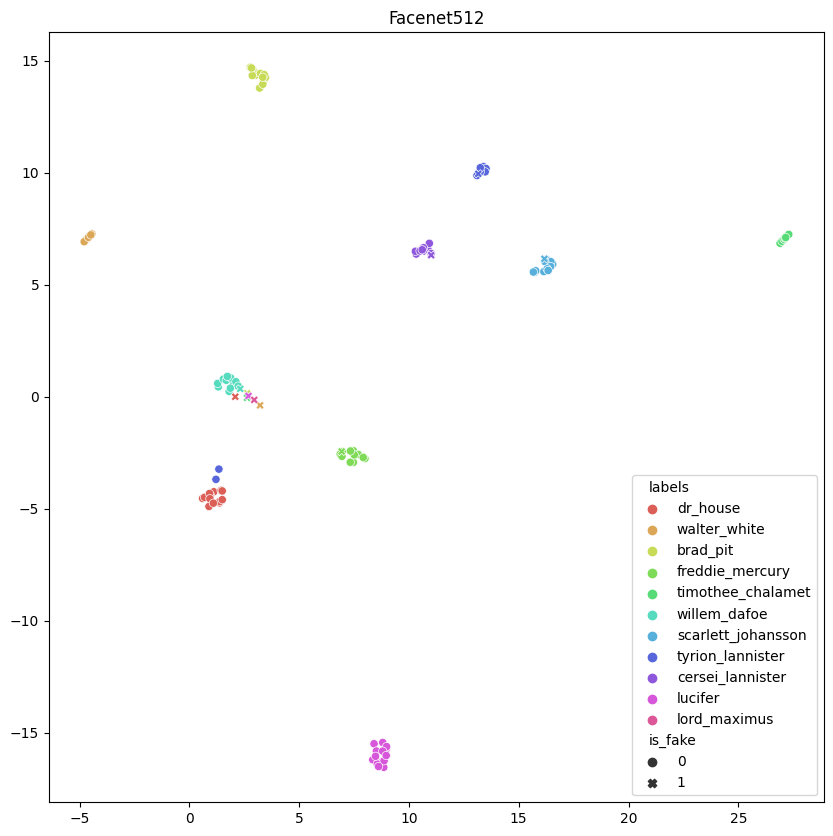

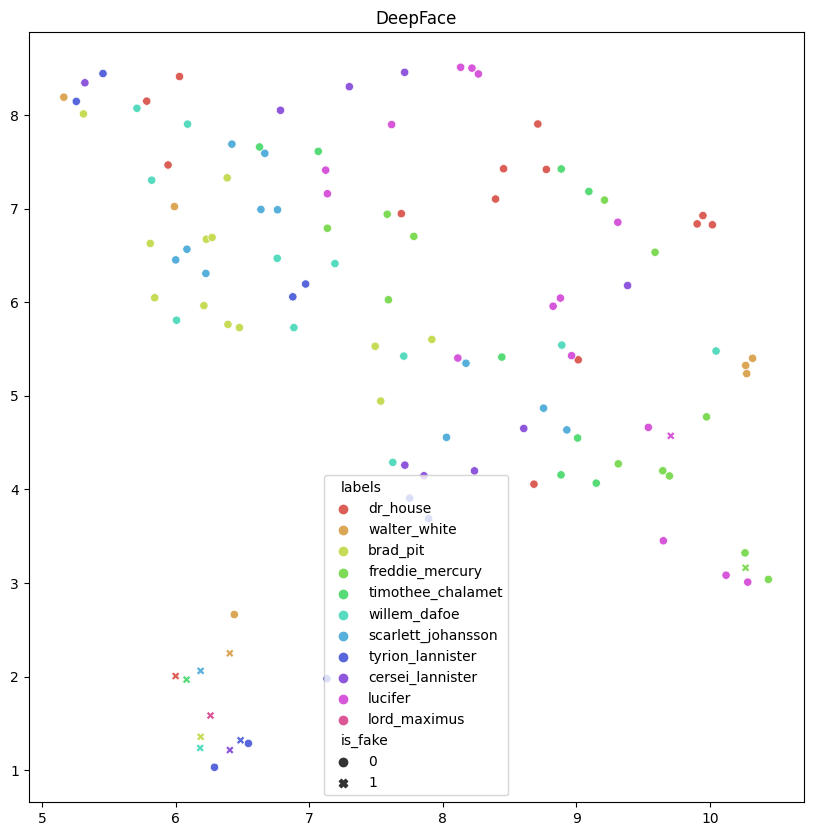

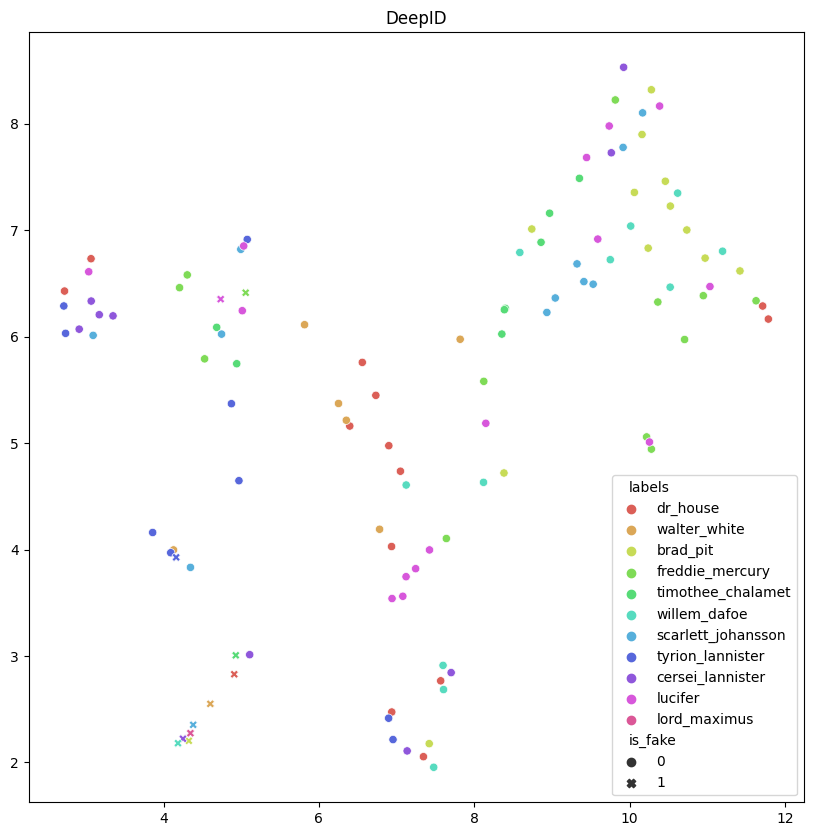

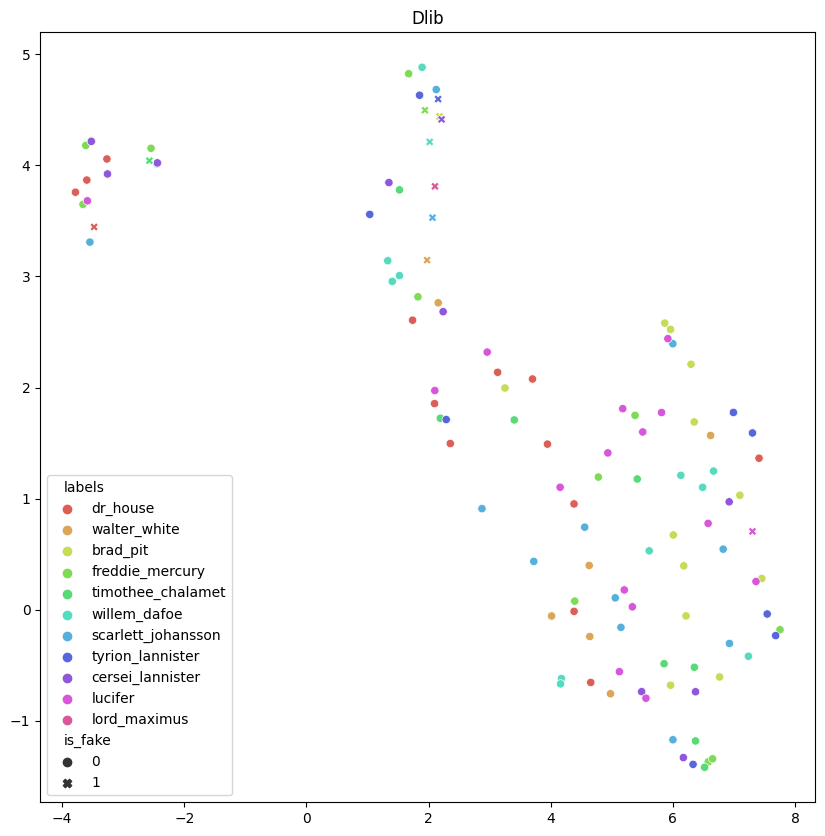

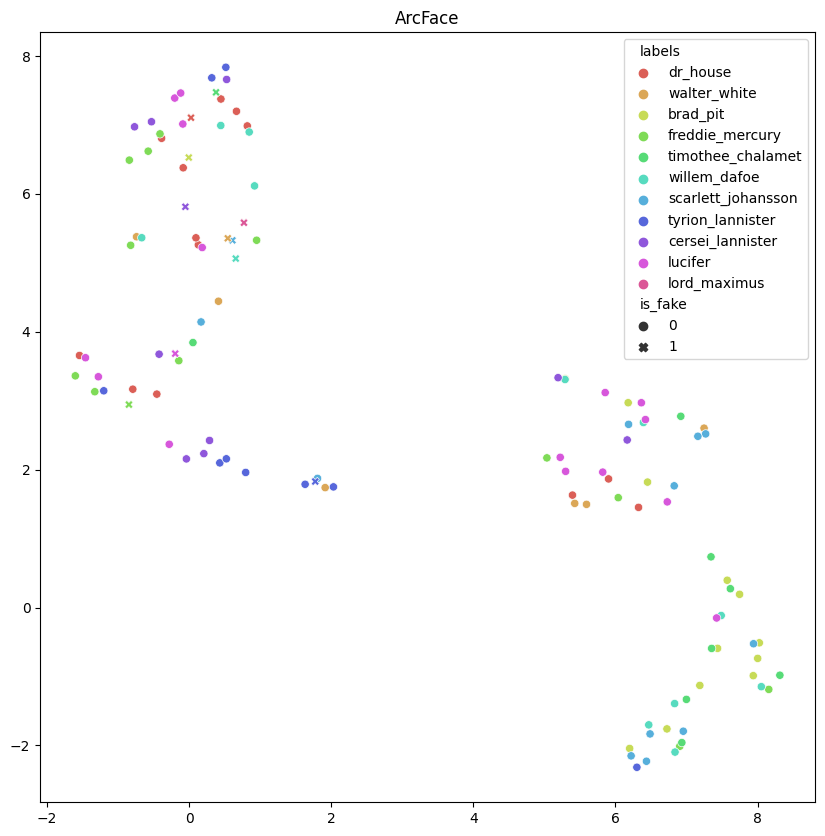

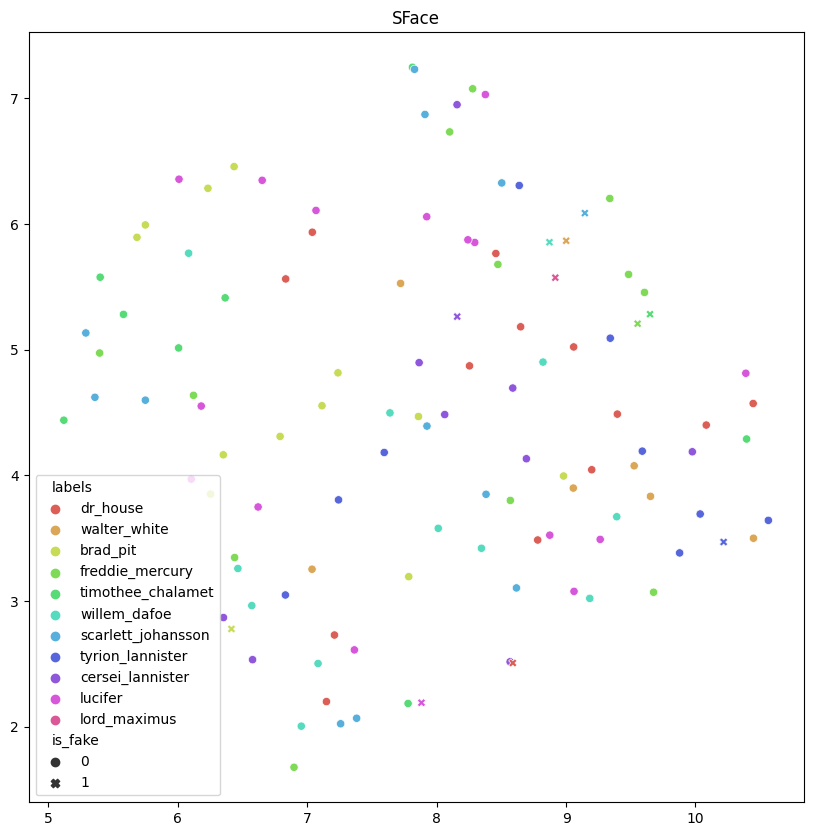

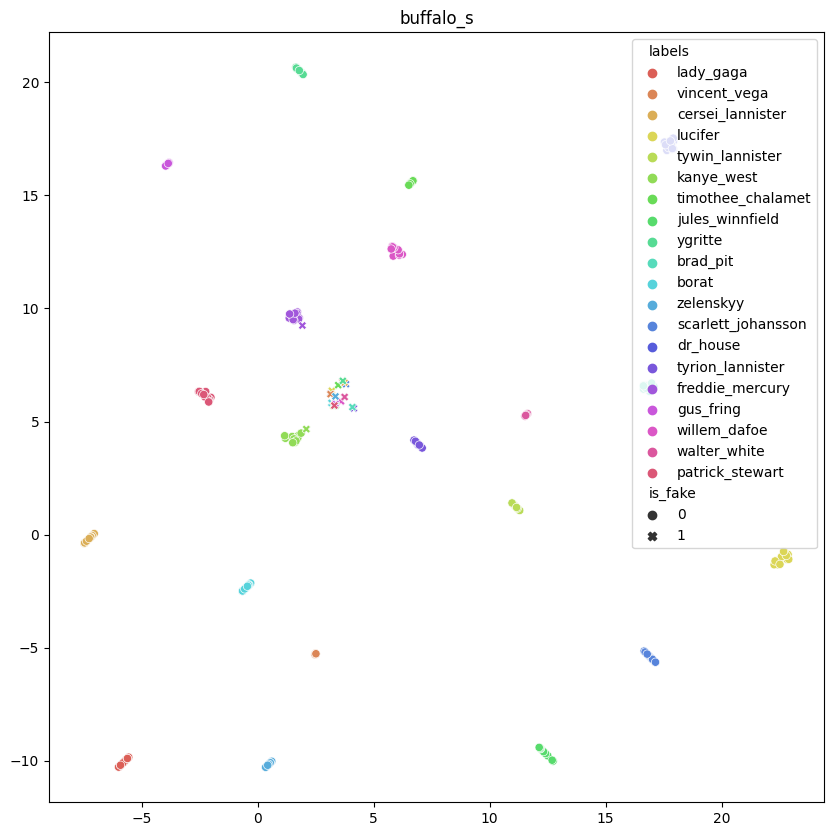

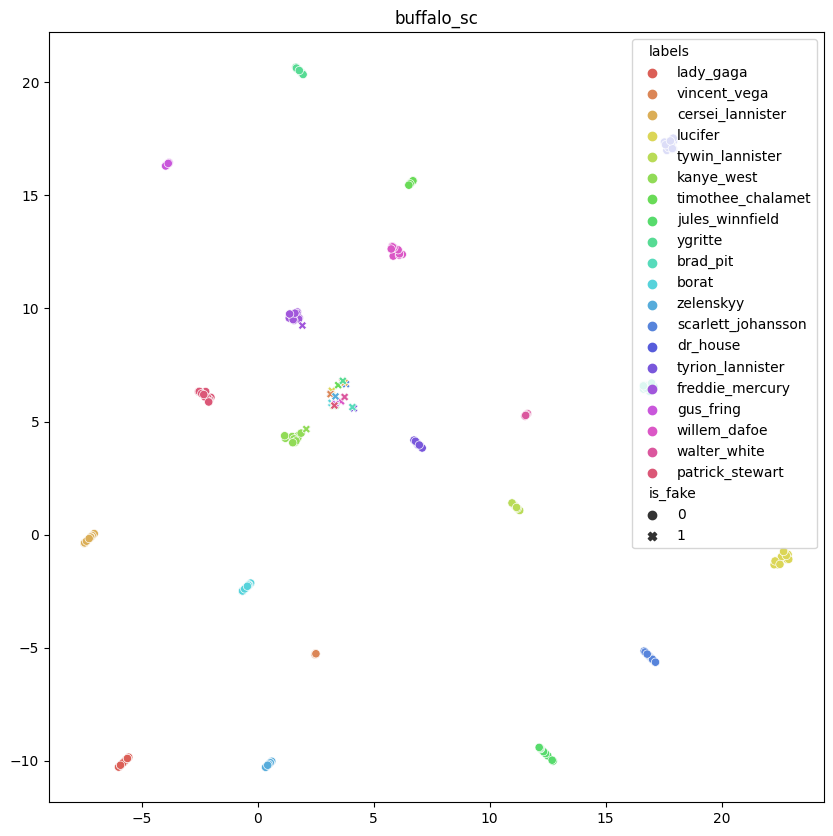

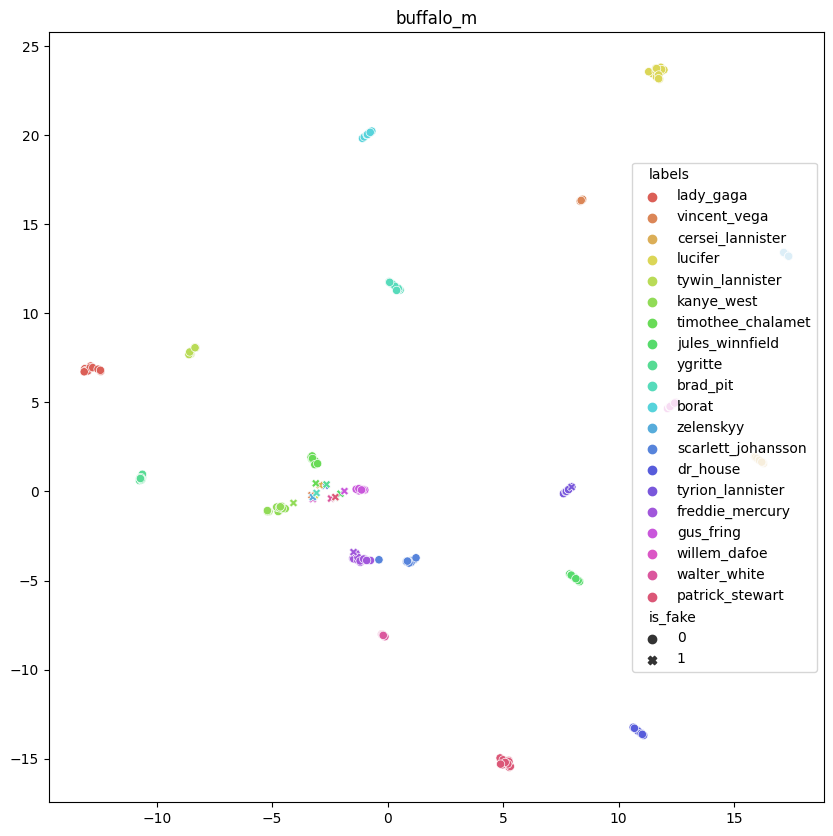

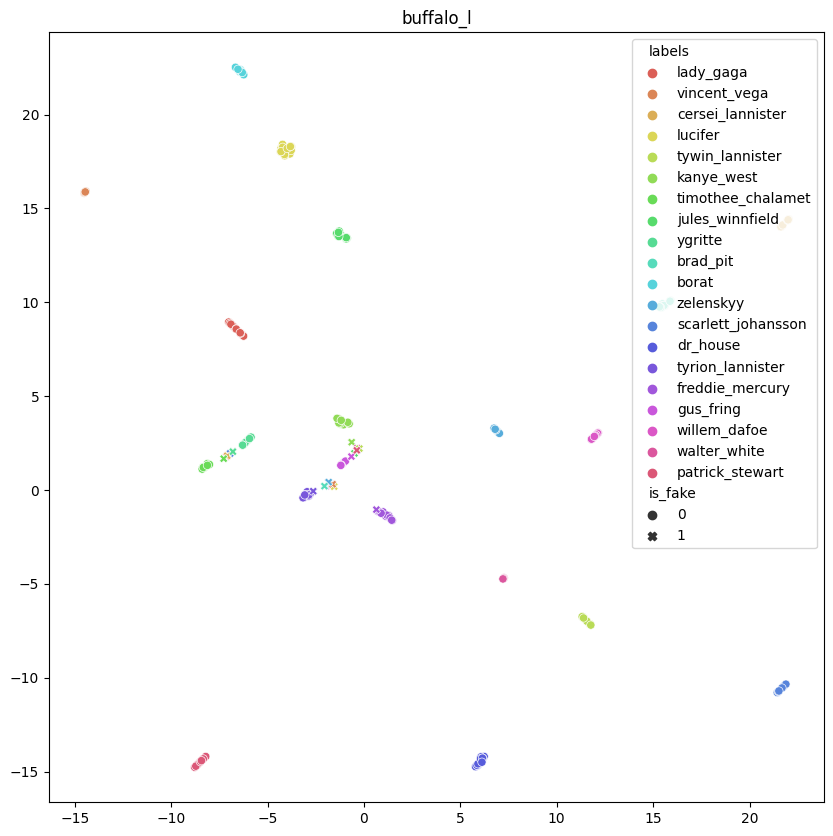

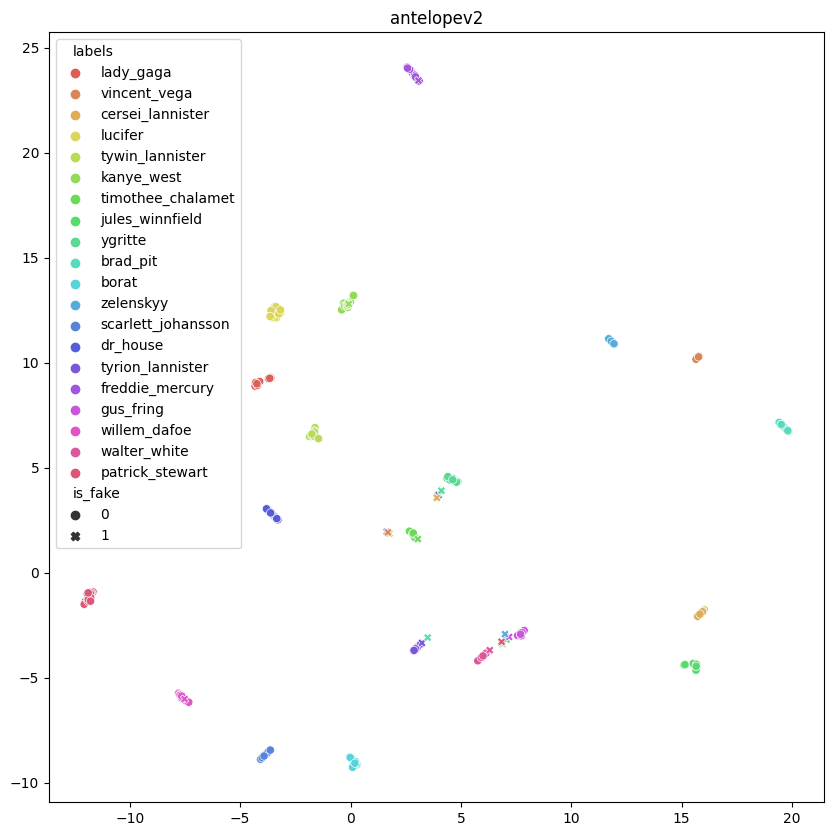

In [ ]:
for model, umap_embedding in model2umap.items():
    plt.figure(figsize=(10, 10))
    sns.scatterplot(
        x=umap_embedding[:,0], y=umap_embedding[:,1],
        hue=model2df[model]["labels"],
        style=model2df[model]["is_fake"],
        palette=sns.color_palette("hls", len(model2df[model]["labels"].unique()))
    )
    plt.title(model)
    plt.show()

# Feature selection

In [58]:
# choose N features that are closest to the mean of the embeddings
def get_least_varied_features(real_embeddings: np.ndarray, fake_embedding: np.ndarray, n=10) -> np.ndarray:
    mean_embedding = np.mean(real_embeddings, axis=0)
    distances = mean_embedding - fake_embedding
    sorted_distances = np.argsort(distances)
    return sorted_distances[:n]

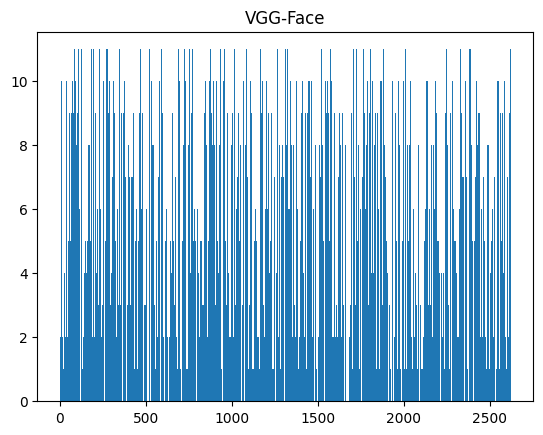

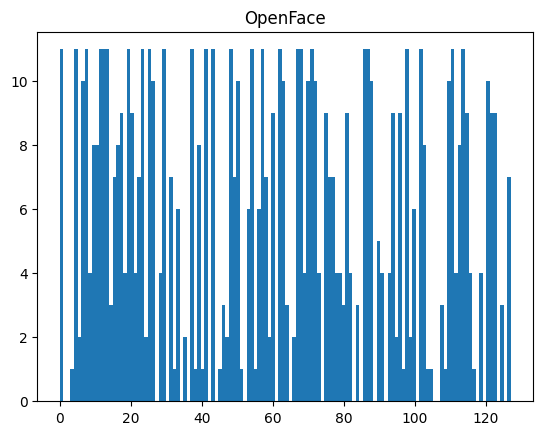

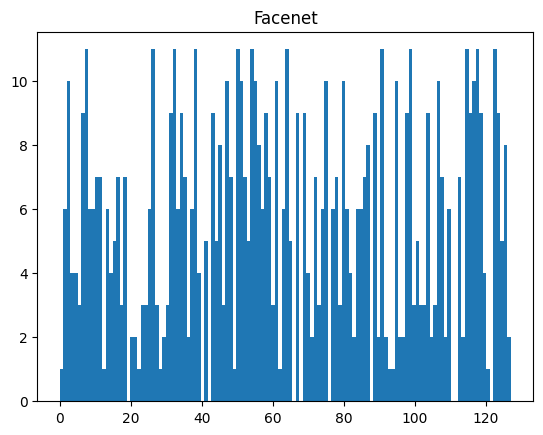

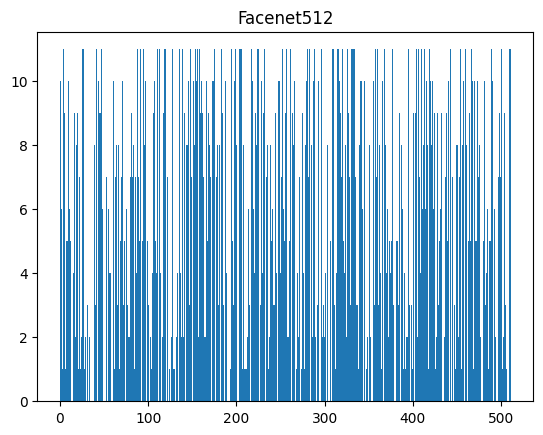

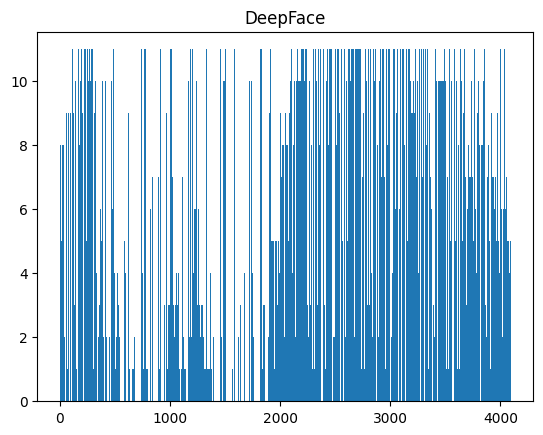

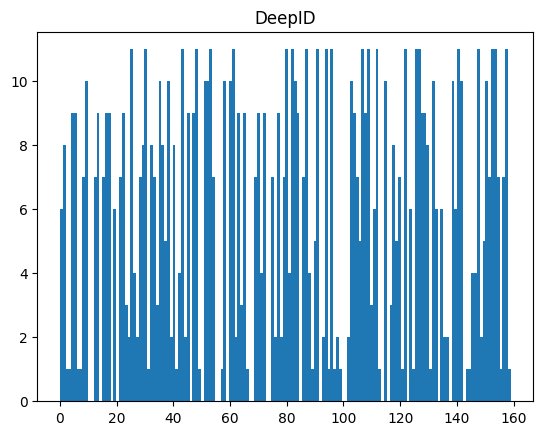

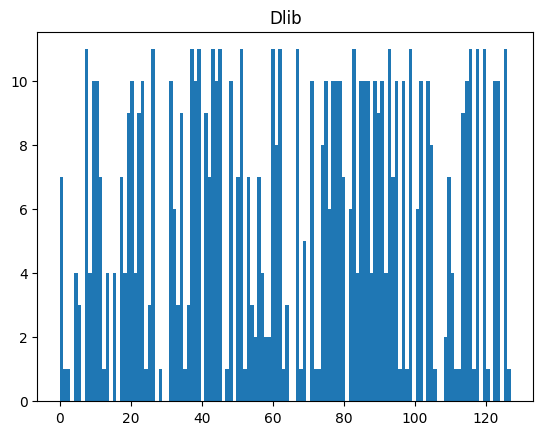

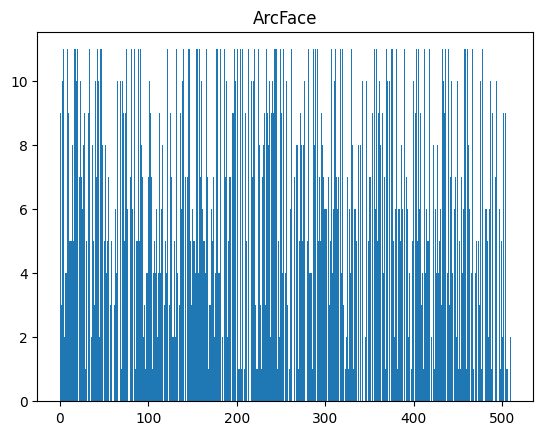

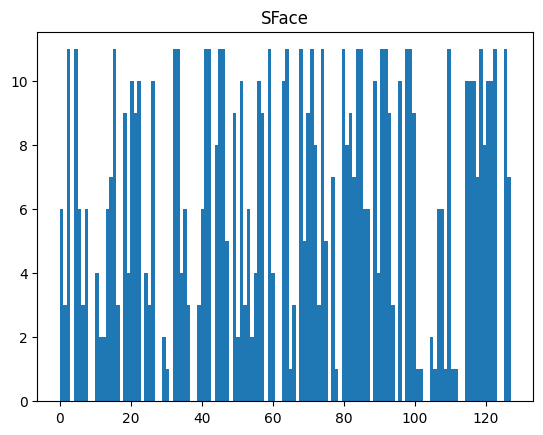

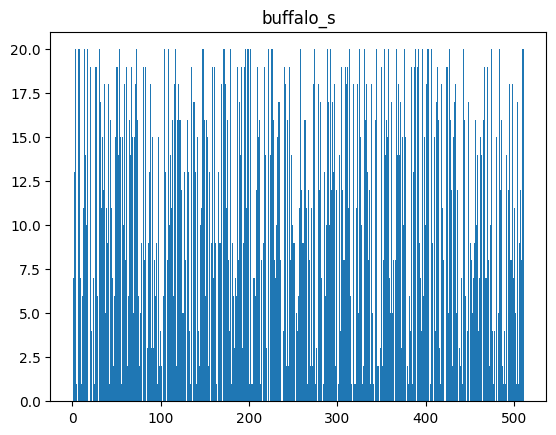

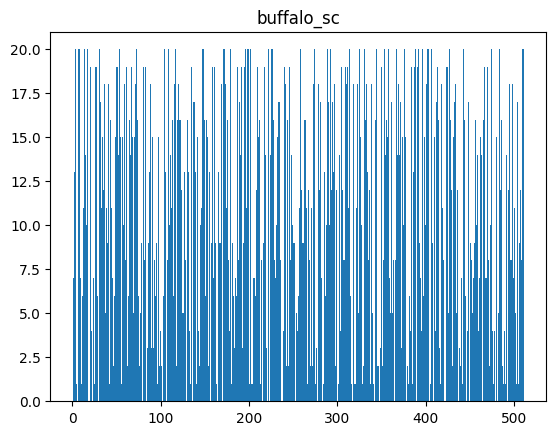

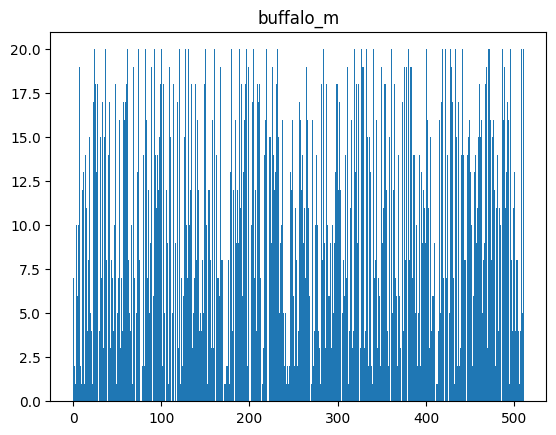

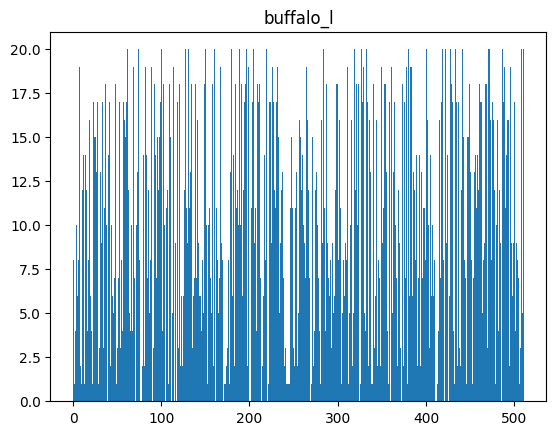

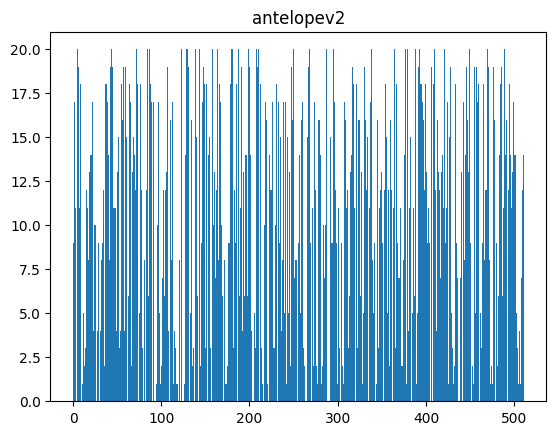

In [64]:
for model, model_df in model2df.items():
    least_varied_features = []
    for label in model_df["labels"].unique():
        real_embeddings = model_df[model_df["labels"] == label]["embeddings"].values.tolist()
        fake_embedding = model_df[model_df["is_fake"] == 1]["embeddings"].values.tolist()[0]
        embedding_size = len(real_embeddings[0])
        n_features = int(embedding_size * 0.5)
        features = get_least_varied_features(real_embeddings, fake_embedding, n=n_features)
        least_varied_features += features.tolist()
    plt.hist(least_varied_features, bins=embedding_size)
    plt.title(model)
    plt.show()